<a href="https://colab.research.google.com/github/Taise-Kojima/HomeCredit_cmp/blob/main/HomeCredit_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
!pip install optuna
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import re
import pickle
import gc
import optuna

# scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# LightGBM
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [137]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [138]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。

INPUT_DIR = "/content/drive/My Drive/GCI/cmp2/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
"""
df = pd.read_csv(INPUT + 'kaggle/application_train.csv')
test_df = pd.read_csv(INPUT + 'kaggle/application_test.csv')
sample_df = pd.read_csv(INPUT + 'kaggle/sample_submission.csv')
"""

"\ndf = pd.read_csv(INPUT + 'kaggle/application_train.csv')\ntest_df = pd.read_csv(INPUT + 'kaggle/application_test.csv')\nsample_df = pd.read_csv(INPUT + 'kaggle/sample_submission.csv')\n"

In [139]:
# コンペのデータセットのファイルパス
"""
INPUT_DIR = "/content/drive/My Drive/GCI/cmp2/"
train_comp = pd.read_csv(INPUT_DIR + "train.csv")
test_comp = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub_comp = pd.read_csv(INPUT_DIR + "sample_submission.csv")

# Kaggleのデータセットのファイルパス
INPUT_KAGGLE_DIR = "/content/drive/My Drive/GCI/cmp2/kaggle/"
train_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + 'application_train.csv')
test_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + 'application_test.csv')
sample_sub_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + 'sample_submission.csv')

# コンペデータのカラムに存在するカラムのみを選択
common_columns_train = train_comp.columns.intersection(train_kaggle.columns)
common_columns_test = test_comp.columns.intersection(test_kaggle.columns)

train = train_kaggle[common_columns_train]
test = test_kaggle[common_columns_test]
"""

'\nINPUT_DIR = "/content/drive/My Drive/GCI/cmp2/"\ntrain_comp = pd.read_csv(INPUT_DIR + "train.csv")\ntest_comp = pd.read_csv(INPUT_DIR + "test.csv")\nsample_sub_comp = pd.read_csv(INPUT_DIR + "sample_submission.csv")\n\n# Kaggleのデータセットのファイルパス\nINPUT_KAGGLE_DIR = "/content/drive/My Drive/GCI/cmp2/kaggle/"\ntrain_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + \'application_train.csv\')\ntest_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + \'application_test.csv\')\nsample_sub_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + \'sample_submission.csv\')\n\n# コンペデータのカラムに存在するカラムのみを選択\ncommon_columns_train = train_comp.columns.intersection(train_kaggle.columns)\ncommon_columns_test = test_comp.columns.intersection(test_kaggle.columns)\n\ntrain = train_kaggle[common_columns_train]\ntest = test_kaggle[common_columns_test]\n'

In [140]:

#ダウンサンプリング 1対10から1対7にする

# クラスごとのデータを分ける
class_0 = train[train['TARGET'] == 0]
class_1 = train[train['TARGET'] == 1]

# クラス1のサンプル数を取得
n_class_1 = len(class_1)

# クラス0をダウンサンプリングして、クラス1のサンプル数の4倍にする
n_samples_class_0 = n_class_1 * 7
class_0_downsampled = resample(class_0,
                               replace=False,  # サンプルの重複を許可しない
                               n_samples=n_samples_class_0,  # クラス1のサンプル数の4倍にする
                               random_state=42)  # 再現性のためのシード

# ダウンサンプリングされたデータとクラス1のデータを結合
train_downsampled = pd.concat([class_0_downsampled, class_1])

# シャッフルしてデータセットを混ぜる
train = train_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)


In [141]:
#フラグの平均、分散、合計
flag_columns = ['FLAG_OWN_CAR',
                 'FLAG_OWN_REALTY',
                 'FLAG_MOBIL',
                 'FLAG_EMP_PHONE',
                 'FLAG_WORK_PHONE',
                 'FLAG_CONT_MOBILE',
                 'FLAG_PHONE',
                 'FLAG_EMAIL',
                 'REG_REGION_NOT_LIVE_REGION',
                 'REG_REGION_NOT_WORK_REGION',
                 'LIVE_REGION_NOT_WORK_REGION',
                 'REG_CITY_NOT_WORK_CITY',
                 'LIVE_CITY_NOT_WORK_CITY']

# FLAG_OWN_CARとFLAG_OWN_REALTYを数値データに変換
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)


train['FLAG_AVELEGE'] = train[flag_columns].mean(axis=1)
test['FLAG_AVELEGE'] = test[flag_columns].mean(axis=1)
train['FLAG_STD'] = train[flag_columns].std(axis=1)
test['FLAG_STD'] = test[flag_columns].std(axis=1)
train['FLAG_SUM'] = train[flag_columns].sum(axis=1)
test['FLAG_SUM'] = test[flag_columns].sum(axis=1)


In [142]:
print(train['CNT_FAM_MEMBERS'].dtype)

# CNT_FAM_MEMBERS を数値型に強制変換
train['CNT_FAM_MEMBERS'] = pd.to_numeric(train['CNT_FAM_MEMBERS'], errors='coerce')
test['CNT_FAM_MEMBERS'] = pd.to_numeric(test['CNT_FAM_MEMBERS'], errors='coerce')

# 平均値を再計算
TRAIN_CNT_FAM_MEMBERS_MEAN = train['CNT_FAM_MEMBERS'].mean()
TEST_CNT_FAM_MEMBERS_MEAN = test['CNT_FAM_MEMBERS'].mean()

# 欠損値を平均値で埋める
train['CNT_FAM_MEMBERS'].fillna(TRAIN_CNT_FAM_MEMBERS_MEAN, inplace=True)
test['CNT_FAM_MEMBERS'].fillna(TEST_CNT_FAM_MEMBERS_MEAN, inplace=True)

# 結果の確認
print("Updated Train CNT_FAM_MEMBERS Mean:", TRAIN_CNT_FAM_MEMBERS_MEAN)
print("Updated Test CNT_FAM_MEMBERS Mean:", TEST_CNT_FAM_MEMBERS_MEAN)

float64
Updated Train CNT_FAM_MEMBERS Mean: 2.154694933342981
Updated Test CNT_FAM_MEMBERS Mean: 2.153593495934959


In [143]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.isnull().sum())

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        3
AMT_GOODS_PRICE                  104
NAME_TYPE_SUITE                  466
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                    73134
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [144]:
train_income_org = train.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].median().to_dict()
train['ORGANIZATIOM_MEDIAN'] = train['ORGANIZATION_TYPE'].map(train_income_org)

test_income_org = test.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].median().to_dict()
test['ORGANIZATIOM_MEDIAN'] = test['ORGANIZATION_TYPE'].map(test_income_org)

train['ORGANIZATION_DIFFERNCE'] = train['AMT_INCOME_TOTAL'] - train['ORGANIZATIOM_MEDIAN']
test['ORGANIZATION_DIFFERNCE'] = test['AMT_INCOME_TOTAL'] - test['ORGANIZATIOM_MEDIAN']


In [145]:
train["DAYS_ID_PUBLISH"] = train["DAYS_ID_PUBLISH"].abs()
test["DAYS_ID_PUBLISH"] = test["DAYS_ID_PUBLISH"].abs()

"""
import matplotlib.pyplot as plt
# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割
train['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))

# 各ビンで TARGET が 1 の割合を計算
grouped = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean() * 100  # 結果をパーセンテージで

# 可視化
plt.figure(figsize=(10, 6))
grouped.plot(kind='bar', color='skyblue')
plt.title('TARGET = 1の割合（DAYS_ID_PUBLISH毎の500日間隔のビン）')
plt.xlabel('DAYS_ID_PUBLISH Bin')
plt.ylabel('TARGET = 1の割合 (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
"""

"\nimport matplotlib.pyplot as plt\n# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割\ntrain['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))\n\n# 各ビンで TARGET が 1 の割合を計算\ngrouped = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean() * 100  # 結果をパーセンテージで\n\n# 可視化\nplt.figure(figsize=(10, 6))\ngrouped.plot(kind='bar', color='skyblue')\nplt.title('TARGET = 1の割合（DAYS_ID_PUBLISH毎の500日間隔のビン）')\nplt.xlabel('DAYS_ID_PUBLISH Bin')\nplt.ylabel('TARGET = 1の割合 (%)')\nplt.xticks(rotation=45)\nplt.grid(True)\nplt.show()\n"

In [146]:
"""
# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割
train['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))
test['DAYS_ID_PUBLISH_BIN'] = pd.cut(test['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))

# trainデータセットで TARGET が 1 の割合を計算
rate_per_bin = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean()

# 新しい特徴量 'DAYS_ID_PUBLISH_RATE' を追加
train['DAYS_ID_PUBLISH_RATE'] = train['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)
test['DAYS_ID_PUBLISH_RATE'] = test['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)
"""

"\n# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割\ntrain['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))\ntest['DAYS_ID_PUBLISH_BIN'] = pd.cut(test['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))\n\n# trainデータセットで TARGET が 1 の割合を計算\nrate_per_bin = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean()\n\n# 新しい特徴量 'DAYS_ID_PUBLISH_RATE' を追加\ntrain['DAYS_ID_PUBLISH_RATE'] = train['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)\ntest['DAYS_ID_PUBLISH_RATE'] = test['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)\n"

In [147]:
# AMT_ANNUITYの平均値を計算
mean_amt_annuity = train['AMT_ANNUITY'].mean()
mean_amt_annuity_test = test['AMT_ANNUITY'].mean()

# 欠損値を平均値で補完
train['AMT_ANNUITY'].fillna(mean_amt_annuity, inplace=True)
test['AMT_ANNUITY'].fillna(mean_amt_annuity_test, inplace=True)

mean_amt_annuity = train['AMT_GOODS_PRICE'].mean()
train['AMT_GOODS_PRICE'].fillna(mean_amt_annuity, inplace=True)

mean_amt_annuity_test = test['AMT_GOODS_PRICE'].mean()
test['AMT_GOODS_PRICE'].fillna(mean_amt_annuity_test, inplace=True)

# EXT_SOURCE_2の欠損値を平均値で補完
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)

In [148]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.isnull().sum())

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        0
AMT_GOODS_PRICE                    0
NAME_TYPE_SUITE                  466
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                    73134
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [149]:
train['DAYS_EMPLOYED_REC'] = train['DAYS_EMPLOYED'] - train['DAYS_BIRTH']
test['DAYS_EMPLOYED_REC'] = test['DAYS_EMPLOYED'] - test['DAYS_BIRTH']
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
train['CHILDREM_RAITON'] = train['CNT_CHILDREN'] / train['CNT_FAM_MEMBERS']
test['CHILDREM_RAITON'] = test['CNT_CHILDREN'] / test['CNT_FAM_MEMBERS']


In [150]:

train['DSCR'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] * 100 #収入に対する年間返済額
train['Repayment_Rate'] = train['AMT_ANNUITY'] / train['AMT_CREDIT'] * 100 #返済率
train['DTI'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL'] #DTI クライアントがどれだけの負債を背負っているか
# 返済率が4.65%を超えるかどうかに基づいて新しい特徴量を作成
train['High_Repayment'] = (train['Repayment_Rate'] > 4.65).astype(int)


In [151]:
"""
# High_Repaymentが1で、TARGETも1のデータのみをフィルタリング
target_1_high_repayment = train[(train['High_Repayment'] == 1) & (train['TARGET'] == 1)]

# High_Repaymentが1で、TARGETも1のデータ数をカウント
count_target_1 = target_1_high_repayment.shape[0]

# High Repaymentのデータの総数
count_high_repayment = train[train['High_Repayment'] == 1].shape[0]
# TARGETの全データの数
total_target_count = train['TARGET'].count()

# TARGETが1のデータの数をカウント
count_target_1_total = train[train['TARGET'] == 1].shape[0]

# 全データの数
total_count = train.shape[0]


# TARGETの総数（非欠損値の数）
total_target_count = train['TARGET'].count()

# TARGETが1の割合を計算
percentage_target_1 = (count_target_1_total / total_count) * 100

# 結果を表示
print(f"全データの中でTARGETが1のデータの数: {count_target_1_total}, TARGETの総数:{total_target_count}, 全データにおけるTARGETが1の割合: {percentage_target_1:.2f}%")
print(f"High Repaymentの中でTARGETが1のデータの数: {count_target_1}, High Repaymentの総数: {count_high_repayment}, 割合は: {count_target_1/count_high_repayment * 100:.2f}%")
"""

'\n# High_Repaymentが1で、TARGETも1のデータのみをフィルタリング\ntarget_1_high_repayment = train[(train[\'High_Repayment\'] == 1) & (train[\'TARGET\'] == 1)]\n\n# High_Repaymentが1で、TARGETも1のデータ数をカウント\ncount_target_1 = target_1_high_repayment.shape[0]\n\n# High Repaymentのデータの総数\ncount_high_repayment = train[train[\'High_Repayment\'] == 1].shape[0]\n# TARGETの全データの数\ntotal_target_count = train[\'TARGET\'].count()\n\n# TARGETが1のデータの数をカウント\ncount_target_1_total = train[train[\'TARGET\'] == 1].shape[0]\n\n# 全データの数\ntotal_count = train.shape[0]\n\n\n# TARGETの総数（非欠損値の数）\ntotal_target_count = train[\'TARGET\'].count()\n\n# TARGETが1の割合を計算\npercentage_target_1 = (count_target_1_total / total_count) * 100\n\n# 結果を表示\nprint(f"全データの中でTARGETが1のデータの数: {count_target_1_total}, TARGETの総数:{total_target_count}, 全データにおけるTARGETが1の割合: {percentage_target_1:.2f}%")\nprint(f"High Repaymentの中でTARGETが1のデータの数: {count_target_1}, High Repaymentの総数: {count_high_repayment}, 割合は: {count_target_1/count_high_repayment * 100:.2f}%")\n'

In [152]:

test['DSCR'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL'] * 100 #
test['Repayment_Rate'] = test['AMT_ANNUITY'] / test['AMT_CREDIT'] * 100 #返済率
test['DTI'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL'] * 100 #DTI クライアントがどれだけの負債を背負っているか
test['High_Repayment'] = (test['Repayment_Rate'] > 4.65).astype(int)


In [153]:
# [仮説]　外部機関によるスコアが平均的に高い方が貸し倒れリスクが低いと考えられる。
train["EXT_SOURCE_mean"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
train["EXT_SOURCE_max"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
train["EXT_SOURCE_min"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
train["EXT_SOURCE_std"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
train["EXT_SOURCE_count"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)
"""
# 中央値
train["EXT_SOURCE_median"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)
# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）
train["EXT_SOURCE_mode"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]
# 範囲
train["EXT_SOURCE_range"] = train["EXT_SOURCE_max"] - train["EXT_SOURCE_min"]
# 分散
train["EXT_SOURCE_var"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)
# 歪度
train["EXT_SOURCE_skew"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)
# 尖度
train["EXT_SOURCE_kurtosis"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)
"""

'\n# 中央値\ntrain["EXT_SOURCE_median"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)\n# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）\ntrain["EXT_SOURCE_mode"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]\n# 範囲\ntrain["EXT_SOURCE_range"] = train["EXT_SOURCE_max"] - train["EXT_SOURCE_min"]\n# 分散\ntrain["EXT_SOURCE_var"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)\n# 歪度\ntrain["EXT_SOURCE_skew"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)\n# 尖度\ntrain["EXT_SOURCE_kurtosis"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)\n'

In [154]:
# [仮説]　外部機関によるスコアが平均的に高い方が貸し倒れリスクが低いと考えられる。
test["EXT_SOURCE_mean"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
test["EXT_SOURCE_max"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
test["EXT_SOURCE_min"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
test["EXT_SOURCE_std"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
test["EXT_SOURCE_count"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)
"""
# 中央値
test["EXT_SOURCE_median"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)
# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）
test["EXT_SOURCE_mode"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]
# 範囲
test["EXT_SOURCE_range"] = test["EXT_SOURCE_max"] - test["EXT_SOURCE_min"]
# 分散
test["EXT_SOURCE_var"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)
# 歪度
test["EXT_SOURCE_skew"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)
# 尖度
test["EXT_SOURCE_kurtosis"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)
"""

'\n# 中央値\ntest["EXT_SOURCE_median"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)\n# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）\ntest["EXT_SOURCE_mode"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]\n# 範囲\ntest["EXT_SOURCE_range"] = test["EXT_SOURCE_max"] - test["EXT_SOURCE_min"]\n# 分散\ntest["EXT_SOURCE_var"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)\n# 歪度\ntest["EXT_SOURCE_skew"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)\n# 尖度\ntest["EXT_SOURCE_kurtosis"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)\n'

In [155]:
# OWN_CAR_AGEをグループ分け
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

# OWN_CAR_AGEをOne Hot Encoding
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)


In [156]:
train['DOWN_PAYMENT'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
test['DOWN_PAYMENT'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
train['DOWN_PAYMENT_RATE'] = train['DOWN_PAYMENT'] / train['AMT_CREDIT'] * 100
test['DOWN_PAYMENT_RATE'] = test['DOWN_PAYMENT'] / test['AMT_CREDIT'] * 100
# DOWN_PAYMENT_RATEが-30以下であれば1, それ以上であれば0をセット
train['DOWN_PAYMENT_RATE_ALART'] = (train['DOWN_PAYMENT_RATE'] <=-30).astype(int) *100
test['DOWN_PAYMENT_RATE_ALART'] = (test['DOWN_PAYMENT_RATE'] <= -30).astype(int) * 100


In [157]:
train['EMPLOYMENT_TO_AGE_RATIO'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
test['EMPLOYMENT_TO_AGE_RATIO'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']


In [158]:
train['SOCIAL_CIRCLE_DEFAULT_RATE'] = train['DEF_30_CNT_SOCIAL_CIRCLE'] / train['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, 1)
test['SOCIAL_CIRCLE_DEFAULT_RATE'] = test['DEF_30_CNT_SOCIAL_CIRCLE'] / test['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, 1)


In [159]:

train_client_age = train['DAYS_BIRTH'] // 365 * (-1)
train_loan_years = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test_client_age = test['DAYS_BIRTH'] // 365 * (-1)
test_loan_years = test['AMT_CREDIT'] / test['AMT_ANNUITY']
train['FINISH_AGE'] = train_client_age + train_loan_years
test['FINISH_AGE'] = test_client_age + test_loan_years


In [160]:
def calculate_w_city_rate(region_rating):
    if region_rating == 1:
        return 4.745279
    elif region_rating == 2:
        return 7.936173
    elif region_rating == 3:
        return 11.351307
    else:
        return None

train['W_CITY_RATE'] = train['REGION_RATING_CLIENT_W_CITY'].apply(calculate_w_city_rate)
test['W_CITY_RATE'] = test['REGION_RATING_CLIENT_W_CITY'].apply(calculate_w_city_rate)


In [161]:
train['CITY_EVALUATION'] = train['REGION_RATING_CLIENT_W_CITY'] - train['REGION_RATING_CLIENT']
test['CITY_EVALUATION'] = test['REGION_RATING_CLIENT_W_CITY'] - test['REGION_RATING_CLIENT']


In [162]:
"""
# 'CITY_EVALUATION' がマイナスのサブセットをフィルタリング
negative_city_eval = train[train['CITY_EVALUATION'] == -1]

# 'TARGET' が 1 のレコードの割合を計算（CITY_EVALUATIONがマイナスのサブセットで）
target_ones_percentage_negative = (negative_city_eval[negative_city_eval['TARGET'] == 1].shape[0] / negative_city_eval.shape[0]) * 100

# 全体で 'TARGET' が 1 のレコードの割合を計算
total_target_ones_percentage = (train[train['TARGET'] == 1].shape[0] / train.shape[0]) * 100

print(f"全体でTARGETが1である人の割合: {total_target_ones_percentage:.2f}%")
print(f"CITY_EVALUATIONがマイナスの人々の中でTARGETが1である人の割合: {target_ones_percentage_negative:.2f}%")
"""

'\n# \'CITY_EVALUATION\' がマイナスのサブセットをフィルタリング\nnegative_city_eval = train[train[\'CITY_EVALUATION\'] == -1]\n\n# \'TARGET\' が 1 のレコードの割合を計算（CITY_EVALUATIONがマイナスのサブセットで）\ntarget_ones_percentage_negative = (negative_city_eval[negative_city_eval[\'TARGET\'] == 1].shape[0] / negative_city_eval.shape[0]) * 100\n\n# 全体で \'TARGET\' が 1 のレコードの割合を計算\ntotal_target_ones_percentage = (train[train[\'TARGET\'] == 1].shape[0] / train.shape[0]) * 100\n\nprint(f"全体でTARGETが1である人の割合: {total_target_ones_percentage:.2f}%")\nprint(f"CITY_EVALUATIONがマイナスの人々の中でTARGETが1である人の割合: {target_ones_percentage_negative:.2f}%")\n'

In [163]:
"""
train['RATIO_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']
train['RATIO_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']
train['RATIO_HOUR_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']

train['TREND_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 12)
train['TREND_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 4)

train['SEASONALITY_QRT'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_QRT'].mean()
train['SEASONALITY_MON'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_MON'].mean()

train['CUMULATIVE_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] + train['AMT_REQ_CREDIT_BUREAU_MON'] * 30 + train['AMT_REQ_CREDIT_BUREAU_QRT'] * 90

test['RATIO_QRT_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']
test['RATIO_MON_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_MON'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']
test['RATIO_HOUR_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_HOUR'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']

test['TREND_MON_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_MON'] - (test['AMT_REQ_CREDIT_BUREAU_YEAR'] / 12)
test['TREND_QRT_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] - (test['AMT_REQ_CREDIT_BUREAU_YEAR'] / 4)

test['SEASONALITY_QRT'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] / test['AMT_REQ_CREDIT_BUREAU_QRT'].mean()
test['SEASONALITY_MON'] = test['AMT_REQ_CREDIT_BUREAU_MON'] / test['AMT_REQ_CREDIT_BUREAU_MON'].mean()

test['CUMULATIVE_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_HOUR'] + test['AMT_REQ_CREDIT_BUREAU_MON'] * 30 + test['AMT_REQ_CREDIT_BUREAU_QRT'] * 90
"""

"\ntrain['RATIO_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']\ntrain['RATIO_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']\ntrain['RATIO_HOUR_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']\n\ntrain['TREND_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 12)\ntrain['TREND_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 4)\n\ntrain['SEASONALITY_QRT'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_QRT'].mean()\ntrain['SEASONALITY_MON'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_MON'].mean()\n\ntrain['CUMULATIVE_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] + train['AMT_REQ_CREDIT_BUREAU_MON'] * 30 + train['AMT_REQ_CREDIT_BUREAU_QRT'] * 90\n\ntest['RATIO_QRT_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']\ntest['RATIO_MON

In [164]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.isnull().sum())


SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        0
AMT_GOODS_PRICE                    0
NAME_TYPE_SUITE                  466
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

In [165]:
"""
# 数値カラムの抽出
numerical_columns = train.select_dtypes(include=[np.number]).columns

# 0と1以外の値を持ち、かつユニークな値が5つ以上の数値カラムを抽出
filtered_columns = []
for col in numerical_columns:
    unique_values = train[col].unique()
    if not np.all(np.isin(unique_values, [0, 1])) and len(unique_values) >= 5:
        filtered_columns.append(col)

# 条件に一致するカラムのデータフレーム
filtered_df = train[filtered_columns]

import pandas as pd

# Pandasの表示設定を調整
pd.set_option('display.max_columns', None)  # 列の折り返しを無効にする
pd.set_option('display.max_rows', None)  # 行の折り返しを無効にする
pd.set_option('display.max_colwidth', None)  # 列幅の制限を無効にする
pd.set_option('display.width', 1000)  # コンソールの幅を広げる



# 条件に一致するカラムのデータフレームを表示
print(filtered_df)
"""

"\n# 数値カラムの抽出\nnumerical_columns = train.select_dtypes(include=[np.number]).columns\n\n# 0と1以外の値を持ち、かつユニークな値が5つ以上の数値カラムを抽出\nfiltered_columns = []\nfor col in numerical_columns:\n    unique_values = train[col].unique()\n    if not np.all(np.isin(unique_values, [0, 1])) and len(unique_values) >= 5:\n        filtered_columns.append(col)\n\n# 条件に一致するカラムのデータフレーム\nfiltered_df = train[filtered_columns]\n\nimport pandas as pd\n\n# Pandasの表示設定を調整\npd.set_option('display.max_columns', None)  # 列の折り返しを無効にする\npd.set_option('display.max_rows', None)  # 行の折り返しを無効にする\npd.set_option('display.max_colwidth', None)  # 列幅の制限を無効にする\npd.set_option('display.width', 1000)  # コンソールの幅を広げる\n\n\n\n# 条件に一致するカラムのデータフレームを表示\nprint(filtered_df)\n"

In [166]:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み

# 複数の特徴量をリストで指定
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE','FLAG_AVELEGE','INCOME_PER_PERSON',
            'DSCR','Repayment_Rate','DTI',
            'EMPLOYMENT_TO_AGE_RATIO','FINISH_AGE']

# 各特徴量に対してビニングとプロットを実行
for feature in features:
    # 特徴量を10個のビンに分ける
    train['BINNED_' + feature] = pd.qcut(train[feature], q=10, duplicates='drop', labels=False)

    # ビンごとにTARGETの割合（平均）を計算
    binned_data = train.groupby('BINNED_' + feature)['TARGET'].mean().reset_index()

    # プロットの設定
    plt.figure(figsize=(10, 6))

    # データと正しい引数を用いて棒グラフを作成
    sns.barplot(x='BINNED_' + feature, y='TARGET', data=binned_data)

    plt.title(f'TARGET rate by Bins of {feature}')
    plt.xlabel(f'Bins of {feature}')
    plt.ylabel('Average of TARGET')
    plt.show()
    """

"\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# データの読み込み\n\n# 複数の特徴量をリストで指定\nfeatures = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE','FLAG_AVELEGE','INCOME_PER_PERSON',\n            'DSCR','Repayment_Rate','DTI',\n            'EMPLOYMENT_TO_AGE_RATIO','FINISH_AGE']\n\n# 各特徴量に対してビニングとプロットを実行\nfor feature in features:\n    # 特徴量を10個のビンに分ける\n    train['BINNED_' + feature] = pd.qcut(train[feature], q=10, duplicates='drop', labels=False)\n    \n    # ビンごとにTARGETの割合（平均）を計算\n    binned_data = train.groupby('BINNED_' + feature)['TARGET'].mean().reset_index()\n    \n    # プロットの設定\n    plt.figure(figsize=(10, 6))\n    \n    # データと正しい引数を用いて棒グラフを作成\n    sns.barplot(x='BINNED_' + feature, y='TARGET', data=binned_data)\n    \n    plt.title(f'TARGET rate by Bins of {feature}')\n    plt.xlabel(f'Bins of 

In [167]:
# 特徴量リスト
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
            'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
            'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
            'FLAG_AVELEGE', 'INCOME_PER_PERSON', 'Repayment_Rate', 'DTI',
            'EMPLOYMENT_TO_AGE_RATIO', 'FINISH_AGE']

# 特徴量ごとのグループ割り当て設定
# 例: AMT_INCOME_TOTALでビン0とビン1をGroup1に、ビン2とビン3をGroup2に割り当てる
groupings = {
    'AMT_INCOME_TOTAL': {0: 'Group2', 1: 'Group3', 2: 'Group2', 3: 'Group2', 4: 'Group3', 5: 'Group1', 6: 'Group1', 7: 'Group3', 8: 'Group4', 9: 'Group4'},
    'AMT_CREDIT': {0: 'Group13', 1: 'Group2', 2: 'Group2', 3: 'Group1', 4: 'Group1', 5: 'Group1', 6: 'Group2', 7: 'Group3', 8: 'Group3', 9: 'Group4'},
    'AMT_ANNUITY': {0: 'Group3', 1: 'Group3', 2: 'Group2', 3: 'Group2', 4: 'Group3', 5: 'Group2', 6: 'Group1', 7: 'Group3', 8: 'Group3', 9: 'Group4'},
    'AMT_GOODS_PRICE': {0: 'Group3', 1: 'Group3', 2: 'Group3', 3: 'Group2', 4: 'Group1', 5: 'Group4', 6: 'Group3', 7: 'Group5', 8: 'Group4', 9: 'Group5'},
    'REGION_POPULATION_RELATIVE': {0: 'Group1', 1: 'Group1', 2: 'Group2', 3: 'Group2', 4: 'Group1', 5: 'Group1', 6: 'Group2', 7: 'Group2', 8: 'Group2', 9: 'Group3'},
    'DAYS_BIRTH': {0: 'Group10', 1: 'Group9', 2: 'Group8', 3: 'Group7', 4: 'Group6', 5: 'Group5', 6: 'Group4', 7: 'Group3', 8: 'Group2', 9: 'Group1'},
    'DAYS_EMPLOYED': {0: 'Group9', 1: 'Group8', 2: 'Group7', 3: 'Group6', 4: 'Group5', 5: 'Group4', 6: 'Group2', 7: 'Group3', 8: 'Group1'},
    'DAYS_REGISTRATION': {0: 'Group3', 1: 'Group3', 2: 'Group3', 3: 'Group2', 4: 'Group2', 5: 'Group2', 6: 'Group2', 7: 'Group2', 8: 'Group2', 9: 'Group1'},
    'DAYS_ID_PUBLISH': {0: 'Group10', 1: 'Group9', 2: 'Group8', 3: 'Group7', 4: 'Group6', 5: 'Group4', 6: 'Group5', 7: 'Group3', 8: 'Group2', 9: 'Group1'},
    'DAYS_LAST_PHONE_CHANGE': {0: 'Group4', 1: 'Group4', 2: 'Group4', 3: 'Group3', 4: 'Group3', 5: 'Group2', 6: 'Group2', 7: 'Group1', 8: 'Group2'},
    'FLAG_AVELEGE': {0: 'Group3', 1: 'Group2', 2: 'Group2', 3: 'Group1', 4: 'Group1', 5: 'Group1'},
    'INCOME_PER_PERSON': {0: 'Group1', 1: 'Group1', 2: 'Group2', 3: 'Group2', 4: 'Group1', 5: 'Group1', 6: 'Group3', 7: 'Group3', 8: 'Group3', 9: 'Group3'},
    'Repayment_Rate': {0: 'Grou4', 1: 'Group3', 2: 'Group3', 3: 'Group4', 4: 'Group2', 5: 'Group2', 6: 'Group2', 7: 'Group2', 8: 'Group1', 9: 'Group4'},
    'DTI': {0: 'Group3', 1: 'Group2', 2: 'Group2', 3: 'Group1', 4: 'Group2', 5: 'Group1', 6: 'Group1', 7: 'Group3', 8: 'Group3', 9: 'Group3'},
    'EMPLOYMENT_TO_AGE_RATIO': {0: 'Group4', 1: 'Group4', 2: 'Group1', 3: 'Group1', 4: 'Group1', 5: 'Group2', 6: 'Group2', 7: 'Group3', 8: 'Group3', 9: 'Group4'},
    'FINISH_AGE': {0: 'Group1', 1: 'Group1', 2: 'Group2', 3: 'Group3', 4: 'Group3', 5: 'Group4', 6: 'Group4', 7: 'Group5', 8: 'Group5', 9: 'Group5'}
}

# train と test に対してビンとグループ割り当てを行う
for feature in features:
    # train データでビン分けの境界を計算
    train[f'BINNED_{feature}'], bins = pd.qcut(train[feature], q=10, retbins=True, labels=False, duplicates='drop')

    # test データに同じビンを適用
    test[f'BINNED_{feature}'] = pd.cut(test[feature], bins=bins, labels=False, include_lowest=True)

    # train と test データでグループ割り当て
    if feature in groupings:
        train[f'GROUPED_{feature}'] = train[f'BINNED_{feature}'].map(groupings[feature]).fillna('Other')
        test[f'GROUPED_{feature}'] = test[f'BINNED_{feature}'].map(groupings[feature]).fillna('Other')

    # 不要なビンカラムを削除
    train.drop(columns=[f'BINNED_{feature}'], inplace=True)
    test.drop(columns=[f'BINNED_{feature}'], inplace=True)

# 結果の表示
print(train[[f'GROUPED_{feature}' for feature in features]].head())
print(test[[f'GROUPED_{feature}' for feature in features]].head())

  GROUPED_AMT_INCOME_TOTAL GROUPED_AMT_CREDIT GROUPED_AMT_ANNUITY  \
0                   Group3            Group13              Group3   
1                   Group3             Group3              Group3   
2                   Group3             Group2              Group3   
3                   Group2             Group2              Group2   
4                   Group2             Group2              Group3   

  GROUPED_AMT_GOODS_PRICE GROUPED_REGION_POPULATION_RELATIVE  \
0                  Group3                             Group2   
1                  Group4                             Group1   
2                  Group3                             Group2   
3                  Group3                             Group2   
4                  Group3                             Group1   

  GROUPED_DAYS_BIRTH GROUPED_DAYS_EMPLOYED GROUPED_DAYS_REGISTRATION  \
0             Group1                Group5                    Group2   
1             Group4                Group8              

In [383]:
#特定の特徴量を選択
# 連続値特徴量
"""
features_numerical = ['SK_ID_CURR',
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR', 'ORGANIZATIOM_MEDIAN', 'ORGANIZATION_DIFFERNCE',
    'DAYS_EMPLOYED_REC', 'INCOME_PER_PERSON', 'CHILDREM_RAITON', 'DSCR', 'Repayment_Rate',
    'DTI', 'EXT_SOURCE_mean', 'EXT_SOURCE_max', 'EXT_SOURCE_min', 'EXT_SOURCE_std',
    'EXT_SOURCE_count', 'DOWN_PAYMENT', 'DOWN_PAYMENT_RATE', 'DOWN_PAYMENT_RATE_ALART',

    'EMPLOYMENT_TO_AGE_RATIO', 'SOCIAL_CIRCLE_DEFAULT_RATE', 'FINISH_AGE', 'W_CITY_RATE'
]

# 離散値特徴量
features_categorical = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'High_Repayment',
    'CITY_EVALUATION', 'GROUPED_AMT_INCOME_TOTAL', 'GROUPED_AMT_CREDIT', 'GROUPED_AMT_ANNUITY',
    'GROUPED_AMT_GOODS_PRICE', 'GROUPED_REGION_POPULATION_RELATIVE', 'GROUPED_DAYS_BIRTH',
    'GROUPED_DAYS_EMPLOYED', 'GROUPED_DAYS_REGISTRATION', 'GROUPED_DAYS_ID_PUBLISH',
    'GROUPED_DAYS_LAST_PHONE_CHANGE', 'GROUPED_FLAG_AVELEGE', 'GROUPED_INCOME_PER_PERSON',
    'GROUPED_Repayment_Rate', 'GROUPED_DTI', 'GROUPED_EMPLOYMENT_TO_AGE_RATIO',
    'GROUPED_FINISH_AGE',
    'OWN_CAR_AGE_0.0', 'OWN_CAR_AGE_1.0', 'OWN_CAR_AGE_2.0',
    'OWN_CAR_AGE_3.0', 'OWN_CAR_AGE_4.0', 'OWN_CAR_AGE_5.0', 'OWN_CAR_AGE_6.0',
    'OWN_CAR_AGE_9.0'
]
"""
numerical_gomi = ['CNT_CHILDREN', 'REGION_POPULATION_RELATIVE','DAYS_REGISTRATION','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
                   'AMT_REQ_CREDIT_BUREAU_MON','ORGANIZATION_DIFFERNCE', 'DAYS_EMPLOYED_REC', 'CHILDREM_RAITON', 'DSCR','DTI',
                   'EXT_SOURCE_max', 'EXT_SOURCE_min', 'EXT_SOURCE_std', 'EXT_SOURCE_count','DOWN_PAYMENT','DOWN_PAYMENT_RATE','DOWN_PAYMENT_RATE_ALART',
                   'EMPLOYMENT_TO_AGE_RATIO','SOCIAL_CIRCLE_DEFAULT_RATE', 'FINISH_AGE',  'W_CITY_RATE' ]

categorical_gomi = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','NAME_TYPE_SUITE',  'NAME_INCOME_TYPE', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE',
                     'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',  'CNT_FAM_MEMBERS','REGION_RATING_CLIENT','REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
                    'LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE',  'High_Repayment','CITY_EVALUATION',
                    'GROUPED_AMT_CREDIT', 'GROUPED_AMT_ANNUITY',
                    'GROUPED_AMT_INCOME_TOTAL', 'GROUPED_AMT_CREDIT', 'GROUPED_AMT_ANNUITY',
                    'GROUPED_AMT_GOODS_PRICE', 'GROUPED_REGION_POPULATION_RELATIVE', 'GROUPED_DAYS_BIRTH',
                    'GROUPED_DAYS_EMPLOYED', 'GROUPED_DAYS_REGISTRATION', 'GROUPED_DAYS_ID_PUBLISH',
                    'GROUPED_DAYS_LAST_PHONE_CHANGE', 'GROUPED_FLAG_AVELEGE', 'GROUPED_INCOME_PER_PERSON',
                    'GROUPED_Repayment_Rate', 'GROUPED_DTI', 'GROUPED_EMPLOYMENT_TO_AGE_RATIO',
                    'GROUPED_FINISH_AGE'
                    ]

features_numerical = ['SK_ID_CURR','EXT_SOURCE_mean','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                      'DAYS_BIRTH',  'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE',
                      'AMT_REQ_CREDIT_BUREAU_HOUR',  'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR', 'ORGANIZATIOM_MEDIAN',
                      'INCOME_PER_PERSON','Repayment_Rate',
                      ]

features_categorical = ['CODE_GENDER', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE', 'FLAG_MOBIL',  'FLAG_EMP_PHONE',
                        'OWN_CAR_AGE_0.0', 'OWN_CAR_AGE_1.0', 'OWN_CAR_AGE_2.0','OWN_CAR_AGE_3.0', 'OWN_CAR_AGE_4.0', 'OWN_CAR_AGE_5.0', 'OWN_CAR_AGE_6.0','OWN_CAR_AGE_9.0',
                        'GROUPED_AMT_CREDIT', 'GROUPED_AMT_ANNUITY',
                    'GROUPED_AMT_INCOME_TOTAL', 'GROUPED_AMT_CREDIT', 'GROUPED_AMT_ANNUITY',
                    'GROUPED_AMT_GOODS_PRICE', 'GROUPED_REGION_POPULATION_RELATIVE', 'GROUPED_DAYS_BIRTH',
                    'GROUPED_DAYS_EMPLOYED', 'GROUPED_DAYS_REGISTRATION', 'GROUPED_DAYS_ID_PUBLISH',
                    'GROUPED_DAYS_LAST_PHONE_CHANGE', 'GROUPED_FLAG_AVELEGE', 'GROUPED_INCOME_PER_PERSON',
                    'GROUPED_Repayment_Rate', 'GROUPED_DTI', 'GROUPED_EMPLOYMENT_TO_AGE_RATIO',
                    'GROUPED_FINISH_AGE'
                        ]

# OrdinalEncoder の初期化
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)


# カテゴリカル特徴量をエンコード
train_cat_encoded = encoder.fit_transform(train[features_categorical])
test_cat_encoded = encoder.transform(test[features_categorical])

# エンコードされたデータをデータフレームに変換
train_cat_encoded = pd.DataFrame(train_cat_encoded, columns=features_categorical, index=train.index)
test_cat_encoded = pd.DataFrame(test_cat_encoded, columns=features_categorical, index=test.index)

# 元のデータから選択した連続値の特徴量を抽出
train_num = train[features_numerical]
test_num = test[features_numerical]

# エンコードされたカテゴリカルデータと数値データを結合
train_processed = pd.concat([train_num, train_cat_encoded], axis=1)
test_processed = pd.concat([test_num, test_cat_encoded], axis=1)

# 結果の表示
print(train_processed.shape)
print(test_processed.shape)

(110568, 35)
(61500, 35)


In [384]:
X_train = train_processed
y_train = train["TARGET"]
id_train = train_processed[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")

# 層化分割したバリデーションのindexのリスト作成
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))

nfold = 0
idx_tr, idx_va = cv[nfold][0], cv[nfold][1]

# 学習データと検証データに分離
x_tr, y_tr, id_tr = X_train.loc[idx_tr, :], y_train[idx_tr], id_train.loc[idx_tr, :]
x_va, y_va, id_va = X_train.loc[idx_va, :], y_train[idx_va], id_train.loc[idx_va, :]

# モデルの学習
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'n_estimators': 1000,
    'max_depth': 10,
    'min_child_samples': 20,
    "random_state": 123,
    "importance_type": "gain",
}

model = lgb.LGBMClassifier(**params)

# 早期停止コールバックの作成
early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=True)

model.fit(x_tr, y_tr,
          eval_set=[(x_va, y_va)],
          callbacks=[early_stopping_callback]
         )

# モデルの保存
with open("model_lgb_fold0.pickle", "wb") as f:
    pickle.dump(model, f, protocol=4)

[LightGBM] [Info] Number of positive: 11057, number of negative: 77397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3783
[LightGBM] [Info] Number of data points in the train set: 88454, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125003 -> initscore=-1.945884
[LightGBM] [Info] Start training from score -1.945884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	valid_0's auc: 0.761984


In [385]:
'''モデル評価'''
# 学習データの推論値取得とROC計算
y_tr_pred = model.predict_proba(x_tr)[:,1]
metric_tr = roc_auc_score(y_tr, y_tr_pred)

# 検証データの推論値取得とROC計算
y_va_pred = model.predict_proba(x_va)[:,1]
metric_va = roc_auc_score(y_va, y_va_pred)

# 評価値を入れる変数の作成（最初のfoldのときのみ）
metrics = []

# 評価値を格納
metrics.append([nfold, metric_tr, metric_va])

# 結果の表示
print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))

[auc] tr:0.8407, va:0.7620


In [386]:
'''説明変数の重要度取得（学習したモデルから説明変数の重要度を取得）'''
# 重要度の取得
imp_fold = pd.DataFrame({"col":X_train.columns, "imp":model.feature_importances_, "nfold":nfold})
# 確認（重要度の上位10個）
display(imp_fold.sort_values("imp", ascending=False)[:20])
#display(imp_fold.sort_values("imp", ascending=False))
# 重要度を格納する5fold用データフレームの作成
imp = pd.DataFrame()
# imp_foldを5fold用データフレームに結合
imp = pd.concat([imp, imp_fold])

,col,imp,nfold
1,EXT_SOURCE_mean,56261.100162,0
20,Repayment_Rate,15410.656048,0
4,EXT_SOURCE_3,9465.754332,0
9,DAYS_BIRTH,7384.499947,0
3,EXT_SOURCE_2,6498.612690,0
10,DAYS_EMPLOYED,5999.160074,0
7,AMT_ANNUITY,5087.064458,0
2,EXT_SOURCE_1,5085.373222,0
8,AMT_GOODS_PRICE,5060.425156,0
11,DAYS_ID_PUBLISH,4625.318905,0


In [387]:
# impが1000以下の列名を取得
low_importance_cols = imp[imp['imp'] <= 100]['col'].unique()

# 低重要度の特徴量名を表示
print("Low importance features (imp <= 100):", low_importance_cols)

Low importance features (imp <= 100): ['FLAG_MOBIL' 'FLAG_EMP_PHONE' 'OWN_CAR_AGE_2.0' 'OWN_CAR_AGE_3.0'
 'OWN_CAR_AGE_4.0' 'OWN_CAR_AGE_5.0' 'OWN_CAR_AGE_6.0' 'OWN_CAR_AGE_9.0']


In [230]:
"""
acc(best)=0.7650
{'num_leaves': 8,
 'min_child_samples': 162,
 'min_sum_hessian_in_leaf': 0.005601209352739659,
 'feature_fraction': 0.9837355499283265,
 'bagging_fraction': 0.9194559319217107,
 'lambda_l1': 1.599804930752984,
 'lambda_l2': 2.007013372654526}
"""

"\nacc(best)=0.7650\n{'num_leaves': 8,\n 'min_child_samples': 162,\n 'min_sum_hessian_in_leaf': 0.005601209352739659,\n 'feature_fraction': 0.9837355499283265,\n 'bagging_fraction': 0.9194559319217107,\n 'lambda_l1': 1.599804930752984,\n 'lambda_l2': 2.007013372654526}\n"

In [388]:
#目的関数の定義
# 探索しないハイパーパラメータ
"""
params_base = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "bagging_freq": 1,
    "random_state": 123,
}

# 目的関数の定義
def objective(trial):
    # 探索するハイパーパラメータ
    params_tuning = {
        #"learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e+2, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e+2, log=True),
    }
    params_tuning.update(params_base)

params_base = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "n_estimators": 1000,
    "bagging_freq": 1,
    "random_state": 123,
    "num_leaves": 8,
    "min_child_samples": 162,
    "min_sum_hessian_in_leaf": 0.005601209352739659,
    "feature_fraction": 0.9837355499283265,
    "bagging_fraction": 0.9194559319217107,
    "lambda_l1": 1.599804930752984,
    "lambda_l2": 2.007013372654526
}

def objective(trial):
    # 探索するハイパーパラメータ
    params_tuning = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
    }
    params_tuning.update(params_base)
"""
params_base = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "bagging_freq": 1,
    "random_state": 123,
}

# 目的関数の定義
def objective(trial):
    params_tuning = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e+2, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e+2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0)
    }
    params_tuning.update(params_base)
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))
    list_fold = [0]  # 処理高速化のために1つめのfoldのみとする。
    for nfold in list_fold:
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = X_train.loc[idx_tr, :], y_train[idx_tr]
        x_va, y_va = X_train.loc[idx_va, :], y_train[idx_va]
        model = lgb.LGBMClassifier(**params_tuning)
        # 早期停止コールバックの作成
        early_stopping_callback = lgb.early_stopping(stopping_rounds=30, verbose=True)

        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_va,y_va)],
                  callbacks=[early_stopping_callback]
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = roc_auc_score(y_va, y_va_pred) # 評価指標をAUCにする
        list_metrics.append(metric_va)

    # 評価指標の算出
    metrics = np.mean(list_metrics)

    return metrics

In [389]:
# tqdm進捗バーを表示するためのコールバック関数を定義
import tqdm

def tqdm_callback(study, trial):
    bar.update(1)

# 既存のコードをそのまま使用しますが、最後に`tqdm`を統合します。
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(sampler=sampler, direction="maximize")

# n_trialsの数だけ進捗バーが更新されるように設定
with tqdm.tqdm(total=100) as bar:
    study.optimize(objective, n_trials=100, callbacks=[tqdm_callback], n_jobs=-1)

[I 2024-07-07 10:28:07,062] A new study created in memory with name: no-name-491b7663-940e-41c5-943f-eb5bbd39154a
  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.758712


[I 2024-07-07 10:28:21,884] Trial 1 finished with value: 0.7587119367878631 and parameters: {'learning_rate': 0.03595301364284723, 'num_leaves': 207, 'min_child_samples': 52, 'min_sum_hessian_in_leaf': 0.0010645214559208158, 'feature_fraction': 0.7412202426600298, 'bagging_fraction': 0.7227907946143035, 'lambda_l1': 4.194016608573109, 'lambda_l2': 0.032302245913788635, 'max_depth': 10, 'colsample_bytree': 0.5814445380939584, 'subsample': 0.5164226788850845}. Best is trial 1 with value: 0.7587119367878631.
  1%|          | 1/100 [00:14<24:26, 14.82s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[664]	valid_0's auc: 0.761388


[I 2024-07-07 10:28:32,630] Trial 0 finished with value: 0.7613881316445851 and parameters: {'learning_rate': 0.003895287289071859, 'num_leaves': 214, 'min_child_samples': 83, 'min_sum_hessian_in_leaf': 0.0007173638140880527, 'feature_fraction': 0.7298429992823918, 'bagging_fraction': 0.8323838436406328, 'lambda_l1': 45.42959490114746, 'lambda_l2': 1.9200131452327784, 'max_depth': 5, 'colsample_bytree': 0.5389415604933547, 'subsample': 0.5201463320378146}. Best is trial 0 with value: 0.7613881316445851.
  2%|▏         | 2/100 [00:25<20:17, 12.42s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[170]	valid_0's auc: 0.759264


[I 2024-07-07 10:28:34,637] Trial 2 finished with value: 0.7592635471940827 and parameters: {'learning_rate': 0.0003308194005542131, 'num_leaves': 222, 'min_child_samples': 96, 'min_sum_hessian_in_leaf': 0.0002422848249343616, 'feature_fraction': 0.9403709196229686, 'bagging_fraction': 0.6590384908997111, 'lambda_l1': 0.0264686458742382, 'lambda_l2': 1.3339348924608365, 'max_depth': 8, 'colsample_bytree': 0.5133368615391833, 'subsample': 0.6860141789087526}. Best is trial 0 with value: 0.7613881316445851.
  3%|▎         | 3/100 [00:27<12:23,  7.67s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[310]	valid_0's auc: 0.764031


[I 2024-07-07 10:28:45,565] Trial 3 finished with value: 0.7640312695154011 and parameters: {'learning_rate': 0.00023470506052023006, 'num_leaves': 139, 'min_child_samples': 136, 'min_sum_hessian_in_leaf': 0.00014942477663476366, 'feature_fraction': 0.7236325987382773, 'bagging_fraction': 0.9257391388754783, 'lambda_l1': 0.02236001213825725, 'lambda_l2': 0.09766278337411129, 'max_depth': 5, 'colsample_bytree': 0.9692718739374877, 'subsample': 0.5042369376908815}. Best is trial 3 with value: 0.7640312695154011.
  4%|▍         | 4/100 [00:38<14:19,  8.96s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[689]	valid_0's auc: 0.759734
Early stopping, best iteration is:
[475]	valid_0's auc: 0.765073


[I 2024-07-07 10:29:04,053] Trial 5 finished with value: 0.7650729946114121 and parameters: {'learning_rate': 0.002515417673218131, 'num_leaves': 234, 'min_child_samples': 126, 'min_sum_hessian_in_leaf': 0.00044687624069601045, 'feature_fraction': 0.5779701001554007, 'bagging_fraction': 0.9453350238010843, 'lambda_l1': 6.868886233612037, 'lambda_l2': 28.078748351132592, 'max_depth': 5, 'colsample_bytree': 0.9953505775713269, 'subsample': 0.6928576456831839}. Best is trial 5 with value: 0.7650729946114121.
  6%|▌         | 6/100 [00:57<12:59,  8.29s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[227]	valid_0's auc: 0.761543


[I 2024-07-07 10:29:17,333] Trial 6 finished with value: 0.7615430208251532 and parameters: {'learning_rate': 0.00011839723279969148, 'num_leaves': 92, 'min_child_samples': 11, 'min_sum_hessian_in_leaf': 0.0001084809392428396, 'feature_fraction': 0.580320303659033, 'bagging_fraction': 0.7114824036404837, 'lambda_l1': 0.8404935633421243, 'lambda_l2': 7.6820007479875665, 'max_depth': 7, 'colsample_bytree': 0.6837025025186754, 'subsample': 0.8180994672371381}. Best is trial 5 with value: 0.7650729946114121.
  7%|▋         | 7/100 [01:10<15:12,  9.81s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[360]	valid_0's auc: 0.761673


[I 2024-07-07 10:29:19,385] Trial 7 finished with value: 0.7616731546610724 and parameters: {'learning_rate': 0.0006368781657790586, 'num_leaves': 19, 'min_child_samples': 133, 'min_sum_hessian_in_leaf': 0.0003363854776757207, 'feature_fraction': 0.8299449063242017, 'bagging_fraction': 0.5705587883752306, 'lambda_l1': 2.4492021735317495, 'lambda_l2': 60.55166352504205, 'max_depth': 6, 'colsample_bytree': 0.6328621540179644, 'subsample': 0.6849200725029995}. Best is trial 5 with value: 0.7650729946114121.
  8%|▊         | 8/100 [01:12<11:15,  7.35s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[111]	valid_0's auc: 0.759641


[I 2024-07-07 10:29:30,027] Trial 9 finished with value: 0.7596414962399548 and parameters: {'learning_rate': 0.00018103801709171716, 'num_leaves': 124, 'min_child_samples': 151, 'min_sum_hessian_in_leaf': 0.001266972991272739, 'feature_fraction': 0.7015555743465111, 'bagging_fraction': 0.7347548842193714, 'lambda_l1': 0.08296450098193368, 'lambda_l2': 0.026108457237267298, 'max_depth': 13, 'colsample_bytree': 0.6910341227791881, 'subsample': 0.7173060495560122}. Best is trial 5 with value: 0.7650729946114121.
  9%|▉         | 9/100 [01:22<12:42,  8.37s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[578]	valid_0's auc: 0.76434


[I 2024-07-07 10:29:36,466] Trial 8 finished with value: 0.7643404869548307 and parameters: {'learning_rate': 0.0017968996370786334, 'num_leaves': 145, 'min_child_samples': 95, 'min_sum_hessian_in_leaf': 1.733882678865994e-05, 'feature_fraction': 0.7653677306162732, 'bagging_fraction': 0.5639209413507558, 'lambda_l1': 2.6345877708880083, 'lambda_l2': 23.475063909479715, 'max_depth': 4, 'colsample_bytree': 0.9674018845039194, 'subsample': 0.6338977521860361}. Best is trial 5 with value: 0.7650729946114121.
 10%|█         | 10/100 [01:29<11:39,  7.78s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[314]	valid_0's auc: 0.759627


[I 2024-07-07 10:29:47,513] Trial 10 finished with value: 0.7596269870651455 and parameters: {'learning_rate': 0.0244917021088731, 'num_leaves': 212, 'min_child_samples': 197, 'min_sum_hessian_in_leaf': 0.000231093604041543, 'feature_fraction': 0.7015291401533932, 'bagging_fraction': 0.7870819519015484, 'lambda_l1': 27.973343489685863, 'lambda_l2': 0.7361509326656578, 'max_depth': 14, 'colsample_bytree': 0.7985165834887323, 'subsample': 0.9893783666744982}. Best is trial 5 with value: 0.7650729946114121.
 11%|█         | 11/100 [01:40<13:01,  8.78s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[617]	valid_0's auc: 0.762818


[I 2024-07-07 10:30:05,869] Trial 12 finished with value: 0.7628182950223807 and parameters: {'learning_rate': 0.001849862231299343, 'num_leaves': 253, 'min_child_samples': 66, 'min_sum_hessian_in_leaf': 1.0115812945881003e-05, 'feature_fraction': 0.5551232238210564, 'bagging_fraction': 0.5004262482733043, 'lambda_l1': 0.5053397806884715, 'lambda_l2': 58.66455943089521, 'max_depth': 3, 'colsample_bytree': 0.9878642124494599, 'subsample': 0.8217990194390249}. Best is trial 5 with value: 0.7650729946114121.
 12%|█▏        | 12/100 [01:58<17:08, 11.69s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[942]	valid_0's auc: 0.76582


[I 2024-07-07 10:30:09,441] Trial 11 finished with value: 0.7658197683767299 and parameters: {'learning_rate': 0.005956229394332295, 'num_leaves': 246, 'min_child_samples': 197, 'min_sum_hessian_in_leaf': 0.008567563490167497, 'feature_fraction': 0.5188536807768107, 'bagging_fraction': 0.9855709373427409, 'lambda_l1': 0.3536514505997793, 'lambda_l2': 0.21346305960206355, 'max_depth': 3, 'colsample_bytree': 0.8558710691493102, 'subsample': 0.9731438901459192}. Best is trial 11 with value: 0.7658197683767299.
 13%|█▎        | 13/100 [02:02<13:23,  9.23s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[963]	valid_0's auc: 0.76543


[I 2024-07-07 10:30:33,124] Trial 13 finished with value: 0.7654302082515323 and parameters: {'learning_rate': 0.003906481785597938, 'num_leaves': 164, 'min_child_samples': 113, 'min_sum_hessian_in_leaf': 0.008834216907964727, 'feature_fraction': 0.6249030578324991, 'bagging_fraction': 0.9979335550839039, 'lambda_l1': 7.453440610969817, 'lambda_l2': 11.14258919334069, 'max_depth': 3, 'colsample_bytree': 0.8847975087995581, 'subsample': 0.6259365474559966}. Best is trial 11 with value: 0.7658197683767299.
 14%|█▍        | 14/100 [02:26<19:29, 13.60s/it]

Early stopping, best iteration is:
[742]	valid_0's auc: 0.764935
Training until validation scores don't improve for 30 rounds


[I 2024-07-07 10:30:36,240] Trial 14 finished with value: 0.7649346713185774 and parameters: {'learning_rate': 0.005836516100720695, 'num_leaves': 251, 'min_child_samples': 199, 'min_sum_hessian_in_leaf': 0.00996288831203791, 'feature_fraction': 0.504287689219342, 'bagging_fraction': 0.9886671139101734, 'lambda_l1': 0.20893994300854418, 'lambda_l2': 0.17126555778349703, 'max_depth': 3, 'colsample_bytree': 0.8611302154038886, 'subsample': 0.9633367603587817}. Best is trial 11 with value: 0.7658197683767299.
 15%|█▌        | 15/100 [02:29<14:46, 10.44s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[256]	valid_0's auc: 0.760182


[I 2024-07-07 10:30:53,131] Trial 16 finished with value: 0.7601823369494086 and parameters: {'learning_rate': 0.007874379245194319, 'num_leaves': 172, 'min_child_samples': 163, 'min_sum_hessian_in_leaf': 0.008108055230553503, 'feature_fraction': 0.6389775050970784, 'bagging_fraction': 0.8729480543879091, 'lambda_l1': 13.352442460142905, 'lambda_l2': 0.3438173569148694, 'max_depth': 11, 'colsample_bytree': 0.8464687038388712, 'subsample': 0.8763832514154658}. Best is trial 11 with value: 0.7658197683767299.
 16%|█▌        | 16/100 [02:46<17:19, 12.38s/it]

Early stopping, best iteration is:
[739]	valid_0's auc: 0.764127
Training until validation scores don't improve for 30 rounds


[I 2024-07-07 10:30:55,141] Trial 15 finished with value: 0.7641273554037327 and parameters: {'learning_rate': 0.009311952454500335, 'num_leaves': 174, 'min_child_samples': 195, 'min_sum_hessian_in_leaf': 0.00995200275634353, 'feature_fraction': 0.6342650837488502, 'bagging_fraction': 0.9908333761347128, 'lambda_l1': 0.23939236547668394, 'lambda_l2': 0.30262978905046894, 'max_depth': 3, 'colsample_bytree': 0.8511274959673458, 'subsample': 0.9847817166357417}. Best is trial 11 with value: 0.7658197683767299.
 17%|█▋        | 17/100 [02:48<12:48,  9.26s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[909]	valid_0's auc: 0.765185


[I 2024-07-07 10:31:16,793] Trial 17 finished with value: 0.7651851228605513 and parameters: {'learning_rate': 0.09400247409763346, 'num_leaves': 172, 'min_child_samples': 29, 'min_sum_hessian_in_leaf': 0.00331636104907649, 'feature_fraction': 0.6379171127799353, 'bagging_fraction': 0.9892176183526826, 'lambda_l1': 0.26225146091555535, 'lambda_l2': 5.439531742710244, 'max_depth': 3, 'colsample_bytree': 0.8919989194263913, 'subsample': 0.9129221759595911}. Best is trial 11 with value: 0.7658197683767299.
 18%|█▊        | 18/100 [03:09<17:44, 12.98s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[867]	valid_0's auc: 0.753971


[I 2024-07-07 10:31:26,530] Trial 18 finished with value: 0.7539562555858452 and parameters: {'learning_rate': 0.0685624277053172, 'num_leaves': 49, 'min_child_samples': 17, 'min_sum_hessian_in_leaf': 0.0031693779060652035, 'feature_fraction': 0.5069689597593224, 'bagging_fraction': 0.8752554208777837, 'lambda_l1': 99.92281466933206, 'lambda_l2': 5.086363803535892, 'max_depth': 7, 'colsample_bytree': 0.9119199410430585, 'subsample': 0.7935786368752592}. Best is trial 11 with value: 0.7658197683767299.
 19%|█▉        | 19/100 [03:19<16:12, 12.01s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[288]	valid_0's auc: 0.764591


[I 2024-07-07 10:31:31,805] Trial 19 finished with value: 0.7645908637072438 and parameters: {'learning_rate': 0.0006383358238992684, 'num_leaves': 33, 'min_child_samples': 177, 'min_sum_hessian_in_leaf': 0.0027028115255194702, 'feature_fraction': 0.503434707718891, 'bagging_fraction': 0.8686675405996642, 'lambda_l1': 1.2629425386495452, 'lambda_l2': 0.010507160962439453, 'max_depth': 7, 'colsample_bytree': 0.772429981620801, 'subsample': 0.793529429647436}. Best is trial 11 with value: 0.7658197683767299.
 20%|██        | 20/100 [03:24<13:19,  9.99s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.762362


[I 2024-07-07 10:31:41,437] Trial 20 finished with value: 0.7623624526488594 and parameters: {'learning_rate': 0.001195893056117922, 'num_leaves': 73, 'min_child_samples': 116, 'min_sum_hessian_in_leaf': 0.0030866001209389677, 'feature_fraction': 0.5484851204016722, 'bagging_fraction': 0.8122739955651608, 'lambda_l1': 1.2181232277864726, 'lambda_l2': 0.012895966026051411, 'max_depth': 12, 'colsample_bytree': 0.7805698343839762, 'subsample': 0.5943193072698882}. Best is trial 11 with value: 0.7658197683767299.
 21%|██        | 21/100 [03:34<13:00,  9.88s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[196]	valid_0's auc: 0.759642


[I 2024-07-07 10:31:46,568] Trial 21 finished with value: 0.759641589726906 and parameters: {'learning_rate': 0.015094481631807826, 'num_leaves': 190, 'min_child_samples': 107, 'min_sum_hessian_in_leaf': 6.367150399098563e-05, 'feature_fraction': 0.5580157916255112, 'bagging_fraction': 0.8009741963257219, 'lambda_l1': 8.155317614403272, 'lambda_l2': 13.141849305861099, 'max_depth': 12, 'colsample_bytree': 0.7368742212544155, 'subsample': 0.5940895381765199}. Best is trial 11 with value: 0.7658197683767299.
 22%|██▏       | 22/100 [03:39<10:59,  8.46s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[552]	valid_0's auc: 0.764594


[I 2024-07-07 10:31:59,251] Trial 22 finished with value: 0.7645936496183863 and parameters: {'learning_rate': 0.08332201342281821, 'num_leaves': 180, 'min_child_samples': 40, 'min_sum_hessian_in_leaf': 0.004795597919184804, 'feature_fraction': 0.6377883798190033, 'bagging_fraction': 0.9975277748578322, 'lambda_l1': 0.0792331826893294, 'lambda_l2': 5.5979385407121365, 'max_depth': 4, 'colsample_bytree': 0.916329292289626, 'subsample': 0.9172353005077845}. Best is trial 11 with value: 0.7658197683767299.
 23%|██▎       | 23/100 [03:52<12:28,  9.72s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[582]	valid_0's auc: 0.763342


[I 2024-07-07 10:32:05,082] Trial 23 finished with value: 0.7633419154354435 and parameters: {'learning_rate': 0.09448015962691342, 'num_leaves': 161, 'min_child_samples': 44, 'min_sum_hessian_in_leaf': 0.005100120478858271, 'feature_fraction': 0.6356369499273082, 'bagging_fraction': 0.9913024900454632, 'lambda_l1': 0.0842319135715652, 'lambda_l2': 4.170217379898264, 'max_depth': 4, 'colsample_bytree': 0.9167985841239644, 'subsample': 0.920826235326794}. Best is trial 11 with value: 0.7658197683767299.
 24%|██▍       | 24/100 [03:58<10:50,  8.56s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[450]	valid_0's auc: 0.764008


[I 2024-07-07 10:32:14,626] Trial 24 finished with value: 0.764008309120213 and parameters: {'learning_rate': 0.0041296489209611265, 'num_leaves': 163, 'min_child_samples': 72, 'min_sum_hessian_in_leaf': 0.0018793287582855062, 'feature_fraction': 0.6128499617455562, 'bagging_fraction': 0.9498799006489393, 'lambda_l1': 0.26749474653002236, 'lambda_l2': 3.378476716361202, 'max_depth': 4, 'colsample_bytree': 0.9096327084009178, 'subsample': 0.9145337017260383}. Best is trial 11 with value: 0.7658197683767299.
 25%|██▌       | 25/100 [04:07<11:03,  8.85s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[732]	valid_0's auc: 0.764044


[I 2024-07-07 10:32:26,733] Trial 25 finished with value: 0.764044114622481 and parameters: {'learning_rate': 0.004577775217294626, 'num_leaves': 117, 'min_child_samples': 66, 'min_sum_hessian_in_leaf': 0.00213948415560935, 'feature_fraction': 0.599288282153086, 'bagging_fraction': 0.9431508494899721, 'lambda_l1': 0.3738696592147019, 'lambda_l2': 14.70700909216991, 'max_depth': 3, 'colsample_bytree': 0.8816378288027543, 'subsample': 0.8991609793779475}. Best is trial 11 with value: 0.7658197683767299.
 26%|██▌       | 26/100 [04:19<12:07,  9.83s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[372]	valid_0's auc: 0.763631


[I 2024-07-07 10:32:31,364] Trial 26 finished with value: 0.7636311640621201 and parameters: {'learning_rate': 0.012192571739865989, 'num_leaves': 128, 'min_child_samples': 32, 'min_sum_hessian_in_leaf': 0.005458984054355884, 'feature_fraction': 0.6799327029483864, 'bagging_fraction': 0.9054232084914506, 'lambda_l1': 0.6075154424446556, 'lambda_l2': 13.411130900830093, 'max_depth': 6, 'colsample_bytree': 0.8317676141948193, 'subsample': 0.8858843246045802}. Best is trial 11 with value: 0.7658197683767299.
 27%|██▋       | 27/100 [04:24<10:03,  8.27s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[275]	valid_0's auc: 0.763115


[I 2024-07-07 10:32:40,075] Trial 27 finished with value: 0.7631149478155841 and parameters: {'learning_rate': 0.014460245085488186, 'num_leaves': 194, 'min_child_samples': 31, 'min_sum_hessian_in_leaf': 0.005238823893034103, 'feature_fraction': 0.6729846144683308, 'bagging_fraction': 0.8915381994092305, 'lambda_l1': 0.6406603117943331, 'lambda_l2': 0.6717623079050404, 'max_depth': 6, 'colsample_bytree': 0.8237368085629649, 'subsample': 0.8528201762447469}. Best is trial 11 with value: 0.7658197683767299.
 28%|██▊       | 28/100 [04:33<10:04,  8.40s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[146]	valid_0's auc: 0.757325


[I 2024-07-07 10:32:45,595] Trial 28 finished with value: 0.7573249269866912 and parameters: {'learning_rate': 0.04836551891653675, 'num_leaves': 188, 'min_child_samples': 180, 'min_sum_hessian_in_leaf': 0.005575478440734471, 'feature_fraction': 0.7784720786151427, 'bagging_fraction': 0.8866914781517836, 'lambda_l1': 0.012403504227300294, 'lambda_l2': 0.6501604362165393, 'max_depth': 15, 'colsample_bytree': 0.8187305109917233, 'subsample': 0.9449756084726196}. Best is trial 11 with value: 0.7658197683767299.
 29%|██▉       | 29/100 [04:38<08:55,  7.54s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[491]	valid_0's auc: 0.764238


[I 2024-07-07 10:32:57,981] Trial 29 finished with value: 0.76423761391385 and parameters: {'learning_rate': 0.03898560945973176, 'num_leaves': 150, 'min_child_samples': 177, 'min_sum_hessian_in_leaf': 0.0015090625125596508, 'feature_fraction': 0.9954872263428105, 'bagging_fraction': 0.9673265210180908, 'lambda_l1': 0.12600695426476927, 'lambda_l2': 0.06777246525593342, 'max_depth': 5, 'colsample_bytree': 0.7269105436378632, 'subsample': 0.9540145150925897}. Best is trial 11 with value: 0.7658197683767299.
 30%|███       | 30/100 [04:50<10:29,  8.99s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[398]	valid_0's auc: 0.764271


[I 2024-07-07 10:33:00,696] Trial 30 finished with value: 0.7642713253084135 and parameters: {'learning_rate': 0.0009588521405912705, 'num_leaves': 233, 'min_child_samples': 84, 'min_sum_hessian_in_leaf': 0.000580169222967833, 'feature_fraction': 0.5331948507557341, 'bagging_fraction': 0.8311639306235482, 'lambda_l1': 0.17332983002032779, 'lambda_l2': 2.325758903897508, 'max_depth': 5, 'colsample_bytree': 0.7308116689571049, 'subsample': 0.7532205228928774}. Best is trial 11 with value: 0.7658197683767299.
 31%|███       | 31/100 [04:53<08:10,  7.11s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[552]	valid_0's auc: 0.76434


[I 2024-07-07 10:33:17,764] Trial 31 finished with value: 0.7643403373757092 and parameters: {'learning_rate': 0.002737223035885518, 'num_leaves': 236, 'min_child_samples': 81, 'min_sum_hessian_in_leaf': 0.0005285347140756633, 'feature_fraction': 0.5298259667355846, 'bagging_fraction': 0.8462597374188192, 'lambda_l1': 2.3031072814130638, 'lambda_l2': 91.71803706417346, 'max_depth': 5, 'colsample_bytree': 0.8763603971146193, 'subsample': 0.7595780207707555}. Best is trial 11 with value: 0.7658197683767299.
 32%|███▏      | 32/100 [05:10<11:26, 10.10s/it]

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.765266


[I 2024-07-07 10:33:28,396] Trial 32 finished with value: 0.7652656151254408 and parameters: {'learning_rate': 0.0037739190273715084, 'num_leaves': 233, 'min_child_samples': 126, 'min_sum_hessian_in_leaf': 0.0004842632372555372, 'feature_fraction': 0.59131959857217, 'bagging_fraction': 0.9606217073027048, 'lambda_l1': 9.253323646123507, 'lambda_l2': 31.17287930288616, 'max_depth': 3, 'colsample_bytree': 0.9537215272521826, 'subsample': 0.6496174954568199}. Best is trial 11 with value: 0.7658197683767299.
 33%|███▎      | 33/100 [05:21<11:27, 10.26s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[849]	valid_0's auc: 0.764675


[I 2024-07-07 10:33:42,521] Trial 33 finished with value: 0.7646748523841043 and parameters: {'learning_rate': 0.0026836566193022726, 'num_leaves': 202, 'min_child_samples': 123, 'min_sum_hessian_in_leaf': 3.543274237784709e-05, 'feature_fraction': 0.5804416348668944, 'bagging_fraction': 0.9626350328984674, 'lambda_l1': 6.6154641771532825, 'lambda_l2': 29.128918243300667, 'max_depth': 3, 'colsample_bytree': 0.9471590816004247, 'subsample': 0.6498325199475028}. Best is trial 11 with value: 0.7658197683767299.
 34%|███▍      | 34/100 [05:35<12:33, 11.42s/it]

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.765114


[I 2024-07-07 10:33:55,030] Trial 34 finished with value: 0.7651140914751119 and parameters: {'learning_rate': 0.007736262454304151, 'num_leaves': 205, 'min_child_samples': 113, 'min_sum_hessian_in_leaf': 4.510942774051091e-05, 'feature_fraction': 0.5969961640872166, 'bagging_fraction': 0.9695160129207463, 'lambda_l1': 13.571775656613715, 'lambda_l2': 33.60723961507501, 'max_depth': 3, 'colsample_bytree': 0.9485207731363154, 'subsample': 0.5539486196813828}. Best is trial 11 with value: 0.7658197683767299.
 35%|███▌      | 35/100 [05:47<12:43, 11.75s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[689]	valid_0's auc: 0.764575


[I 2024-07-07 10:34:04,996] Trial 35 finished with value: 0.764575045715119 and parameters: {'learning_rate': 0.008059776642373378, 'num_leaves': 220, 'min_child_samples': 142, 'min_sum_hessian_in_leaf': 0.003350655088755987, 'feature_fraction': 0.6619848428798292, 'bagging_fraction': 0.9148993422437925, 'lambda_l1': 21.484250388977777, 'lambda_l2': 7.787445958509947, 'max_depth': 4, 'colsample_bytree': 0.9429340412982179, 'subsample': 0.571140478254434}. Best is trial 11 with value: 0.7658197683767299.
 36%|███▌      | 36/100 [05:57<11:57, 11.21s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[575]	valid_0's auc: 0.765181


[I 2024-07-07 10:34:14,515] Trial 36 finished with value: 0.7651814207772879 and parameters: {'learning_rate': 0.02326464921548428, 'num_leaves': 230, 'min_child_samples': 147, 'min_sum_hessian_in_leaf': 0.003665870760454329, 'feature_fraction': 0.6777876548924214, 'bagging_fraction': 0.9276878019097838, 'lambda_l1': 0.03676152566992863, 'lambda_l2': 9.979296059817326, 'max_depth': 4, 'colsample_bytree': 0.8894408914454772, 'subsample': 0.5443082819209246}. Best is trial 11 with value: 0.7658197683767299.
 37%|███▋      | 37/100 [06:07<11:14, 10.70s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[217]	valid_0's auc: 0.75977


[I 2024-07-07 10:34:19,246] Trial 37 finished with value: 0.7597698912185837 and parameters: {'learning_rate': 0.027794424194519565, 'num_leaves': 225, 'min_child_samples': 99, 'min_sum_hessian_in_leaf': 0.0009785597855929437, 'feature_fraction': 0.7406061228925129, 'bagging_fraction': 0.9160253698728085, 'lambda_l1': 0.03588953692163832, 'lambda_l2': 1.7144993813221157, 'max_depth': 8, 'colsample_bytree': 0.8878510820598401, 'subsample': 0.6331638610726913}. Best is trial 11 with value: 0.7658197683767299.
 38%|███▊      | 38/100 [06:12<09:12,  8.91s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.759119


[I 2024-07-07 10:34:26,868] Trial 38 finished with value: 0.7591194651050606 and parameters: {'learning_rate': 0.0037581990952765734, 'num_leaves': 256, 'min_child_samples': 100, 'min_sum_hessian_in_leaf': 0.0008634258600506669, 'feature_fraction': 0.7269819954910153, 'bagging_fraction': 0.6655611239068542, 'lambda_l1': 3.433514341634436, 'lambda_l2': 1.3744719534378425, 'max_depth': 9, 'colsample_bytree': 0.8926792357589588, 'subsample': 0.6313648979912009}. Best is trial 11 with value: 0.7658197683767299.
 39%|███▉      | 39/100 [06:19<08:40,  8.53s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[212]	valid_0's auc: 0.759934


[I 2024-07-07 10:34:33,464] Trial 39 finished with value: 0.7599344095551143 and parameters: {'learning_rate': 0.00040254165295392316, 'num_leaves': 255, 'min_child_samples': 159, 'min_sum_hessian_in_leaf': 0.007745558766452407, 'feature_fraction': 0.7924874718010183, 'bagging_fraction': 0.6933376587884174, 'lambda_l1': 4.381120035693065, 'lambda_l2': 1.0992738377364792, 'max_depth': 9, 'colsample_bytree': 0.945477926752564, 'subsample': 0.7165276023630286}. Best is trial 11 with value: 0.7658197683767299.
 40%|████      | 40/100 [06:26<07:56,  7.95s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[605]	valid_0's auc: 0.760665


[I 2024-07-07 10:34:47,403] Trial 40 finished with value: 0.7606513422856438 and parameters: {'learning_rate': 0.0014516121180711385, 'num_leaves': 102, 'min_child_samples': 158, 'min_sum_hessian_in_leaf': 0.0068855171080188906, 'feature_fraction': 0.6181602776427897, 'bagging_fraction': 0.7725184102532522, 'lambda_l1': 52.51632031898449, 'lambda_l2': 0.06877725914812427, 'max_depth': 5, 'colsample_bytree': 0.9733913269964419, 'subsample': 0.7219167711500095}. Best is trial 11 with value: 0.7658197683767299.
 41%|████      | 41/100 [06:40<09:34,  9.74s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[430]	valid_0's auc: 0.764936


[I 2024-07-07 10:34:50,765] Trial 41 finished with value: 0.764936111017624 and parameters: {'learning_rate': 0.0018251522164499812, 'num_leaves': 103, 'min_child_samples': 52, 'min_sum_hessian_in_leaf': 0.000152584589002763, 'feature_fraction': 0.8699088979696407, 'bagging_fraction': 0.960195853939696, 'lambda_l1': 1.817221828558011, 'lambda_l2': 0.07602660443091602, 'max_depth': 5, 'colsample_bytree': 0.550563906351376, 'subsample': 0.6668646588280122}. Best is trial 11 with value: 0.7658197683767299.
 42%|████▏     | 42/100 [06:43<07:34,  7.83s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[622]	valid_0's auc: 0.765597


[I 2024-07-07 10:35:06,872] Trial 42 finished with value: 0.7655972694331326 and parameters: {'learning_rate': 0.05379687632895436, 'num_leaves': 233, 'min_child_samples': 142, 'min_sum_hessian_in_leaf': 0.004162803697199465, 'feature_fraction': 0.6649850925003132, 'bagging_fraction': 0.9386356937159919, 'lambda_l1': 0.049875129808307786, 'lambda_l2': 9.19441879341258, 'max_depth': 4, 'colsample_bytree': 0.5516436167113846, 'subsample': 0.5302105093577879}. Best is trial 11 with value: 0.7658197683767299.
 43%|████▎     | 43/100 [06:59<09:47, 10.31s/it]

Early stopping, best iteration is:
[579]	valid_0's auc: 0.766238
Training until validation scores don't improve for 30 rounds


[I 2024-07-07 10:35:08,615] Trial 43 finished with value: 0.7662384964306682 and parameters: {'learning_rate': 0.057907862692482354, 'num_leaves': 244, 'min_child_samples': 139, 'min_sum_hessian_in_leaf': 0.0039691312234537085, 'feature_fraction': 0.6578999454501013, 'bagging_fraction': 0.9261230133376906, 'lambda_l1': 0.04533359834007411, 'lambda_l2': 8.901904109647788, 'max_depth': 4, 'colsample_bytree': 0.8655494061890401, 'subsample': 0.5013781430077185}. Best is trial 43 with value: 0.7662384964306682.
 44%|████▍     | 44/100 [07:01<07:13,  7.74s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[575]	valid_0's auc: 0.762548


[I 2024-07-07 10:35:25,871] Trial 44 finished with value: 0.7625480990363366 and parameters: {'learning_rate': 0.044121810096296975, 'num_leaves': 240, 'min_child_samples': 133, 'min_sum_hessian_in_leaf': 0.0017647192498930551, 'feature_fraction': 0.5725162355944345, 'bagging_fraction': 0.968976486217576, 'lambda_l1': 0.010461671799358054, 'lambda_l2': 22.15834450270802, 'max_depth': 3, 'colsample_bytree': 0.5165885429770922, 'subsample': 0.5184819820515538}. Best is trial 43 with value: 0.7662384964306682.
 45%|████▌     | 45/100 [07:18<09:42, 10.60s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[593]	valid_0's auc: 0.765389


[I 2024-07-07 10:35:31,966] Trial 45 finished with value: 0.7653886626504672 and parameters: {'learning_rate': 0.0545359229946625, 'num_leaves': 242, 'min_child_samples': 133, 'min_sum_hessian_in_leaf': 0.0020176417483003255, 'feature_fraction': 0.7109692664962758, 'bagging_fraction': 0.937531734959337, 'lambda_l1': 0.018117328929089536, 'lambda_l2': 20.52045439453115, 'max_depth': 4, 'colsample_bytree': 0.6352038141759071, 'subsample': 0.5104747552955802}. Best is trial 43 with value: 0.7662384964306682.
 46%|████▌     | 46/100 [07:24<08:19,  9.25s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[690]	valid_0's auc: 0.7657


[I 2024-07-07 10:35:49,086] Trial 46 finished with value: 0.7657003855401863 and parameters: {'learning_rate': 0.05667603479678844, 'num_leaves': 243, 'min_child_samples': 123, 'min_sum_hessian_in_leaf': 0.002238187639736793, 'feature_fraction': 0.6920895539368477, 'bagging_fraction': 0.9334971172881371, 'lambda_l1': 0.055384510901627236, 'lambda_l2': 44.73133462409266, 'max_depth': 4, 'colsample_bytree': 0.612592552764979, 'subsample': 0.530349312805128}. Best is trial 43 with value: 0.7662384964306682.
 47%|████▋     | 47/100 [07:42<10:15, 11.61s/it]

Early stopping, best iteration is:
[471]	valid_0's auc: 0.764814
Training until validation scores don't improve for 30 rounds


[I 2024-07-07 10:35:51,304] Trial 47 finished with value: 0.7648142414281814 and parameters: {'learning_rate': 0.060615191609070085, 'num_leaves': 244, 'min_child_samples': 135, 'min_sum_hessian_in_leaf': 0.002409825805986225, 'feature_fraction': 0.7050279589466615, 'bagging_fraction': 0.9335010478401429, 'lambda_l1': 0.0172164292435183, 'lambda_l2': 46.72137109241985, 'max_depth': 6, 'colsample_bytree': 0.6162706699584174, 'subsample': 0.5018455999667844}. Best is trial 43 with value: 0.7662384964306682.
 48%|████▊     | 48/100 [07:44<07:37,  8.79s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[197]	valid_0's auc: 0.76019


[I 2024-07-07 10:36:05,572] Trial 49 finished with value: 0.7601896102342036 and parameters: {'learning_rate': 0.03017683762995135, 'num_leaves': 219, 'min_child_samples': 169, 'min_sum_hessian_in_leaf': 0.0042590295028438144, 'feature_fraction': 0.6618182595107931, 'bagging_fraction': 0.8435108734228809, 'lambda_l1': 0.05188858989963764, 'lambda_l2': 2.807870607569873, 'max_depth': 10, 'colsample_bytree': 0.5638925749402498, 'subsample': 0.5363034408955267}. Best is trial 43 with value: 0.7662384964306682.
 49%|████▉     | 49/100 [07:58<08:52, 10.44s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[438]	valid_0's auc: 0.763191


[I 2024-07-07 10:36:07,978] Trial 48 finished with value: 0.7631910087989917 and parameters: {'learning_rate': 0.06695740040837572, 'num_leaves': 217, 'min_child_samples': 118, 'min_sum_hessian_in_leaf': 0.0040448494872554926, 'feature_fraction': 0.75746570451304, 'bagging_fraction': 0.8457115371253975, 'lambda_l1': 0.057797083832939446, 'lambda_l2': 46.417151166064194, 'max_depth': 6, 'colsample_bytree': 0.5759334049223717, 'subsample': 0.5378028140533653}. Best is trial 43 with value: 0.7662384964306682.
 50%|█████     | 50/100 [08:00<06:41,  8.03s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[569]	valid_0's auc: 0.763965


[I 2024-07-07 10:36:26,703] Trial 51 finished with value: 0.7639652677279305 and parameters: {'learning_rate': 0.01805819610779057, 'num_leaves': 212, 'min_child_samples': 189, 'min_sum_hessian_in_leaf': 0.007047516901821482, 'feature_fraction': 0.6832088459623485, 'bagging_fraction': 0.6093882686958803, 'lambda_l1': 0.14050735351753565, 'lambda_l2': 92.17115495612842, 'max_depth': 4, 'colsample_bytree': 0.6902708276867643, 'subsample': 0.5726477579933971}. Best is trial 43 with value: 0.7662384964306682.
 51%|█████     | 51/100 [08:19<09:10, 11.23s/it]

Early stopping, best iteration is:
[692]	valid_0's auc: 0.76481
Training until validation scores don't improve for 30 rounds


[I 2024-07-07 10:36:29,577] Trial 50 finished with value: 0.7648103149762355 and parameters: {'learning_rate': 0.018194706668755892, 'num_leaves': 212, 'min_child_samples': 190, 'min_sum_hessian_in_leaf': 0.007278793006798675, 'feature_fraction': 0.6924744652050556, 'bagging_fraction': 0.899712452257269, 'lambda_l1': 0.13565221955139667, 'lambda_l2': 96.44886010857236, 'max_depth': 4, 'colsample_bytree': 0.5888777169956836, 'subsample': 0.571863455196638}. Best is trial 43 with value: 0.7662384964306682.
 52%|█████▏    | 52/100 [08:22<06:58,  8.73s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[432]	valid_0's auc: 0.76381


[I 2024-07-07 10:36:41,416] Trial 52 finished with value: 0.7638104907317037 and parameters: {'learning_rate': 0.055053478164773295, 'num_leaves': 237, 'min_child_samples': 144, 'min_sum_hessian_in_leaf': 0.007110501372127735, 'feature_fraction': 0.7050106005598159, 'bagging_fraction': 0.9023834991820892, 'lambda_l1': 0.02544191811563305, 'lambda_l2': 19.03763947177045, 'max_depth': 4, 'colsample_bytree': 0.6538885869311211, 'subsample': 0.5003814083280572}. Best is trial 43 with value: 0.7662384964306682.
 53%|█████▎    | 53/100 [08:34<07:34,  9.66s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[595]	valid_0's auc: 0.765658


[I 2024-07-07 10:36:49,652] Trial 53 finished with value: 0.7656578115826593 and parameters: {'learning_rate': 0.05614717124886689, 'num_leaves': 244, 'min_child_samples': 143, 'min_sum_hessian_in_leaf': 0.0013371983242193403, 'feature_fraction': 0.8034543222424075, 'bagging_fraction': 0.9345222797319505, 'lambda_l1': 0.024945933287811643, 'lambda_l2': 21.794681977303256, 'max_depth': 4, 'colsample_bytree': 0.6357133740031115, 'subsample': 0.5180738017464399}. Best is trial 43 with value: 0.7662384964306682.
 54%|█████▍    | 54/100 [08:42<07:04,  9.23s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[414]	valid_0's auc: 0.76419


[I 2024-07-07 10:36:57,269] Trial 54 finished with value: 0.7641900664505247 and parameters: {'learning_rate': 0.03625847396039716, 'num_leaves': 245, 'min_child_samples': 108, 'min_sum_hessian_in_leaf': 0.001309969408208863, 'feature_fraction': 0.8128898641264856, 'bagging_fraction': 0.9359217604270963, 'lambda_l1': 0.017650636417534303, 'lambda_l2': 7.779033392933714, 'max_depth': 5, 'colsample_bytree': 0.5021211206239609, 'subsample': 0.6140228313933342}. Best is trial 43 with value: 0.7662384964306682.
 55%|█████▌    | 55/100 [08:50<06:33,  8.75s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[488]	valid_0's auc: 0.764083


[I 2024-07-07 10:37:07,832] Trial 55 finished with value: 0.7640826312463307 and parameters: {'learning_rate': 0.03787322253619908, 'num_leaves': 245, 'min_child_samples': 107, 'min_sum_hessian_in_leaf': 0.002575820062627533, 'feature_fraction': 0.8168125878292741, 'bagging_fraction': 0.9776117679536623, 'lambda_l1': 0.032962896158175894, 'lambda_l2': 8.088204414146855, 'max_depth': 5, 'colsample_bytree': 0.533330146794649, 'subsample': 0.6063843546874617}. Best is trial 43 with value: 0.7662384964306682.
 56%|█████▌    | 56/100 [09:00<06:48,  9.29s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[254]	valid_0's auc: 0.762397


[I 2024-07-07 10:37:11,299] Trial 56 finished with value: 0.762396687570349 and parameters: {'learning_rate': 0.07052147808560004, 'num_leaves': 200, 'min_child_samples': 151, 'min_sum_hessian_in_leaf': 0.009624369273939464, 'feature_fraction': 0.8420968225633735, 'bagging_fraction': 0.9849251256776252, 'lambda_l1': 0.033179252095903396, 'lambda_l2': 0.15652381454391326, 'max_depth': 7, 'colsample_bytree': 0.658471981569551, 'subsample': 0.5266114196553341}. Best is trial 43 with value: 0.7662384964306682.
 57%|█████▋    | 57/100 [09:04<05:24,  7.55s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[710]	valid_0's auc: 0.763687


[I 2024-07-07 10:37:27,454] Trial 57 finished with value: 0.7636873123249457 and parameters: {'learning_rate': 0.07122656075876817, 'num_leaves': 226, 'min_child_samples': 150, 'min_sum_hessian_in_leaf': 0.00881951680821632, 'feature_fraction': 0.8415359394044923, 'bagging_fraction': 0.9964742750115633, 'lambda_l1': 0.05550706503599849, 'lambda_l2': 0.14506980817262852, 'max_depth': 3, 'colsample_bytree': 0.6020820232696691, 'subsample': 0.5269894852860343}. Best is trial 43 with value: 0.7662384964306682.
 58%|█████▊    | 58/100 [09:20<07:05, 10.13s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[644]	valid_0's auc: 0.764937


[I 2024-07-07 10:37:29,634] Trial 58 finished with value: 0.7649374759271101 and parameters: {'learning_rate': 0.011448302698366886, 'num_leaves': 228, 'min_child_samples': 127, 'min_sum_hessian_in_leaf': 0.0003287140005847002, 'feature_fraction': 0.8869379112469753, 'bagging_fraction': 0.8750186537130246, 'lambda_l1': 0.05432566966461048, 'lambda_l2': 10.629462976737905, 'max_depth': 3, 'colsample_bytree': 0.6062196008593859, 'subsample': 0.5609399798340827}. Best is trial 43 with value: 0.7662384964306682.
 59%|█████▉    | 59/100 [09:22<05:17,  7.75s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[567]	valid_0's auc: 0.763854


[I 2024-07-07 10:37:43,952] Trial 59 finished with value: 0.7638539060717906 and parameters: {'learning_rate': 0.006160343519195214, 'num_leaves': 249, 'min_child_samples': 126, 'min_sum_hessian_in_leaf': 0.005780045261399758, 'feature_fraction': 0.8865156016781102, 'bagging_fraction': 0.8679385300119534, 'lambda_l1': 0.09652501224127391, 'lambda_l2': 0.41161288869383317, 'max_depth': 3, 'colsample_bytree': 0.7934014110775279, 'subsample': 0.5589147769464239}. Best is trial 43 with value: 0.7662384964306682.
 60%|██████    | 60/100 [09:36<06:28,  9.72s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[691]	valid_0's auc: 0.765833


[I 2024-07-07 10:37:52,738] Trial 60 finished with value: 0.7658328004577122 and parameters: {'learning_rate': 0.021239142752804304, 'num_leaves': 82, 'min_child_samples': 140, 'min_sum_hessian_in_leaf': 0.006039046804072739, 'feature_fraction': 0.6514831658659596, 'bagging_fraction': 0.9510575878973723, 'lambda_l1': 0.09376613136100305, 'lambda_l2': 45.95609897283284, 'max_depth': 4, 'colsample_bytree': 0.803239467279445, 'subsample': 0.5879236960133722}. Best is trial 43 with value: 0.7662384964306682.
 61%|██████    | 61/100 [09:45<06:08,  9.44s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[465]	valid_0's auc: 0.764447


[I 2024-07-07 10:37:59,606] Trial 61 finished with value: 0.7644469685921238 and parameters: {'learning_rate': 0.02136574297016669, 'num_leaves': 252, 'min_child_samples': 140, 'min_sum_hessian_in_leaf': 0.0011963907075727464, 'feature_fraction': 0.7801209998726978, 'bagging_fraction': 0.947349250561219, 'lambda_l1': 0.33079446026600945, 'lambda_l2': 17.48487251178606, 'max_depth': 4, 'colsample_bytree': 0.7563858613385849, 'subsample': 0.5874261348701033}. Best is trial 43 with value: 0.7662384964306682.
 62%|██████▏   | 62/100 [09:52<05:29,  8.67s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[709]	valid_0's auc: 0.765161


[I 2024-07-07 10:38:14,511] Trial 62 finished with value: 0.7651608723454381 and parameters: {'learning_rate': 0.02996112314174235, 'num_leaves': 69, 'min_child_samples': 91, 'min_sum_hessian_in_leaf': 0.0043021220853049725, 'feature_fraction': 0.6535691959315454, 'bagging_fraction': 0.9494441525807121, 'lambda_l1': 0.32520412034475743, 'lambda_l2': 43.39207990713522, 'max_depth': 4, 'colsample_bytree': 0.8532631744677492, 'subsample': 0.587163501590718}. Best is trial 43 with value: 0.7662384964306682.
 63%|██████▎   | 63/100 [10:07<06:29, 10.54s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[704]	valid_0's auc: 0.765414


[I 2024-07-07 10:38:26,177] Trial 63 finished with value: 0.765414165890725 and parameters: {'learning_rate': 0.029497155472260048, 'num_leaves': 88, 'min_child_samples': 169, 'min_sum_hessian_in_leaf': 0.004378152883424632, 'feature_fraction': 0.6239891504112991, 'bagging_fraction': 0.9213500300588429, 'lambda_l1': 0.04719590766366188, 'lambda_l2': 52.80696939534063, 'max_depth': 4, 'colsample_bytree': 0.8560959472616213, 'subsample': 0.5220031603266226}. Best is trial 43 with value: 0.7662384964306682.
 64%|██████▍   | 64/100 [10:19<06:31, 10.88s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[726]	valid_0's auc: 0.765119


[I 2024-07-07 10:38:42,201] Trial 64 finished with value: 0.7651190088887392 and parameters: {'learning_rate': 0.005287780713873591, 'num_leaves': 10, 'min_child_samples': 119, 'min_sum_hessian_in_leaf': 0.0027132813797257458, 'feature_fraction': 0.7387169313677312, 'bagging_fraction': 0.9107573911385095, 'lambda_l1': 0.0783697011027836, 'lambda_l2': 63.301498002006674, 'max_depth': 5, 'colsample_bytree': 0.805593233437295, 'subsample': 0.5221311107127615}. Best is trial 43 with value: 0.7662384964306682.
 65%|██████▌   | 65/100 [10:35<07:14, 12.42s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[734]	valid_0's auc: 0.765001


[I 2024-07-07 10:38:53,292] Trial 65 finished with value: 0.7650014210016566 and parameters: {'learning_rate': 0.09559509761518795, 'num_leaves': 38, 'min_child_samples': 116, 'min_sum_hessian_in_leaf': 0.0027949606209687625, 'feature_fraction': 0.6512617492220796, 'bagging_fraction': 0.9792960885348765, 'lambda_l1': 0.07626621823469745, 'lambda_l2': 66.79459289124422, 'max_depth': 5, 'colsample_bytree': 0.8352225200643618, 'subsample': 0.5439375649606033}. Best is trial 43 with value: 0.7662384964306682.
 66%|██████▌   | 66/100 [10:46<06:48, 12.02s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[863]	valid_0's auc: 0.764758


[I 2024-07-07 10:39:07,181] Trial 66 finished with value: 0.7647583736262094 and parameters: {'learning_rate': 0.09919089374275412, 'num_leaves': 45, 'min_child_samples': 139, 'min_sum_hessian_in_leaf': 0.0015835090837748834, 'feature_fraction': 0.6432268563635406, 'bagging_fraction': 0.9841931498084137, 'lambda_l1': 0.8816588598170598, 'lambda_l2': 0.036977706026733594, 'max_depth': 3, 'colsample_bytree': 0.8681183937264959, 'subsample': 0.5407486427193134}. Best is trial 43 with value: 0.7662384964306682.
 67%|██████▋   | 67/100 [11:00<06:55, 12.58s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[717]	valid_0's auc: 0.764304


[I 2024-07-07 10:39:12,924] Trial 67 finished with value: 0.7643041953204172 and parameters: {'learning_rate': 0.04513188684593806, 'num_leaves': 138, 'min_child_samples': 154, 'min_sum_hessian_in_leaf': 0.003562002256775686, 'feature_fraction': 0.71933889869315, 'bagging_fraction': 0.9548646022621393, 'lambda_l1': 0.02310696840816606, 'lambda_l2': 0.033539337071801144, 'max_depth': 3, 'colsample_bytree': 0.8679795169134368, 'subsample': 0.6143685270281065}. Best is trial 43 with value: 0.7662384964306682.
 68%|██████▊   | 68/100 [11:05<05:36, 10.53s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[368]	valid_0's auc: 0.763671


[I 2024-07-07 10:39:23,777] Trial 68 finished with value: 0.763670802529383 and parameters: {'learning_rate': 0.04752646520132258, 'num_leaves': 138, 'min_child_samples': 130, 'min_sum_hessian_in_leaf': 0.00611349724627342, 'feature_fraction': 0.7169767131404978, 'bagging_fraction': 0.9528242681973782, 'lambda_l1': 0.111083233382409, 'lambda_l2': 4.352581652545885, 'max_depth': 6, 'colsample_bytree': 0.8050934244153516, 'subsample': 0.6041876380237956}. Best is trial 43 with value: 0.7662384964306682.
 69%|██████▉   | 69/100 [11:16<05:29, 10.63s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[329]	valid_0's auc: 0.763164


[I 2024-07-07 10:39:27,547] Trial 69 finished with value: 0.7631641780440287 and parameters: {'learning_rate': 0.08062221646252221, 'num_leaves': 119, 'min_child_samples': 166, 'min_sum_hessian_in_leaf': 0.006250813871852779, 'feature_fraction': 0.6090972310213462, 'bagging_fraction': 0.9991867444083767, 'lambda_l1': 0.013663959853750813, 'lambda_l2': 4.487412661057833, 'max_depth': 6, 'colsample_bytree': 0.7776204513587162, 'subsample': 0.5767149504373935}. Best is trial 43 with value: 0.7662384964306682.
 70%|███████   | 70/100 [11:20<04:17,  8.57s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[495]	valid_0's auc: 0.763575


[I 2024-07-07 10:39:40,000] Trial 70 finished with value: 0.7635752214705872 and parameters: {'learning_rate': 0.07647625369049706, 'num_leaves': 78, 'min_child_samples': 111, 'min_sum_hessian_in_leaf': 0.004981375370282071, 'feature_fraction': 0.6180154867854171, 'bagging_fraction': 0.9990746277101004, 'lambda_l1': 0.18465664000949591, 'lambda_l2': 34.884623291522075, 'max_depth': 4, 'colsample_bytree': 0.7739444159163377, 'subsample': 0.8374949860848466}. Best is trial 43 with value: 0.7662384964306682.
 71%|███████   | 71/100 [11:32<04:42,  9.74s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[611]	valid_0's auc: 0.763961


[I 2024-07-07 10:39:45,849] Trial 71 finished with value: 0.7639608925386194 and parameters: {'learning_rate': 0.019820667347799022, 'num_leaves': 179, 'min_child_samples': 89, 'min_sum_hessian_in_leaf': 0.00959329917287451, 'feature_fraction': 0.6656761474911195, 'bagging_fraction': 0.5216513777835838, 'lambda_l1': 0.16858773575225214, 'lambda_l2': 10.895277563379109, 'max_depth': 4, 'colsample_bytree': 0.7599918823073956, 'subsample': 0.8433370918845667}. Best is trial 43 with value: 0.7662384964306682.
 72%|███████▏  | 72/100 [11:38<03:59,  8.57s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[576]	valid_0's auc: 0.764887


[I 2024-07-07 10:39:58,073] Trial 72 finished with value: 0.764886506841375 and parameters: {'learning_rate': 0.02840776488694294, 'num_leaves': 56, 'min_child_samples': 172, 'min_sum_hessian_in_leaf': 0.004401268124177965, 'feature_fraction': 0.6280954053268981, 'bagging_fraction': 0.922575408663278, 'lambda_l1': 0.04408194024685536, 'lambda_l2': 13.453273432439842, 'max_depth': 4, 'colsample_bytree': 0.8471407370037158, 'subsample': 0.5147347847881896}. Best is trial 43 with value: 0.7662384964306682.
 73%|███████▎  | 73/100 [11:51<04:21,  9.67s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[562]	valid_0's auc: 0.765257


[I 2024-07-07 10:40:03,722] Trial 73 finished with value: 0.7652566964703067 and parameters: {'learning_rate': 0.028766686661712948, 'num_leaves': 65, 'min_child_samples': 174, 'min_sum_hessian_in_leaf': 0.004463236538770336, 'feature_fraction': 0.6244500569100725, 'bagging_fraction': 0.9221081158662522, 'lambda_l1': 0.04456099419873956, 'lambda_l2': 15.009049891328608, 'max_depth': 4, 'colsample_bytree': 0.8402585691151613, 'subsample': 0.5172095242034831}. Best is trial 43 with value: 0.7662384964306682.
 74%|███████▍  | 74/100 [11:56<03:39,  8.46s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[797]	valid_0's auc: 0.765074


[I 2024-07-07 10:40:25,660] Trial 74 finished with value: 0.7650737985991916 and parameters: {'learning_rate': 0.032279236307954824, 'num_leaves': 81, 'min_child_samples': 187, 'min_sum_hessian_in_leaf': 0.0021221029333831046, 'feature_fraction': 0.5226977626607086, 'bagging_fraction': 0.9254752310389355, 'lambda_l1': 0.06658306637370384, 'lambda_l2': 24.18635047124264, 'max_depth': 3, 'colsample_bytree': 0.7162869368410293, 'subsample': 0.5509166671121677}. Best is trial 43 with value: 0.7662384964306682.
 75%|███████▌  | 75/100 [12:18<05:12, 12.50s/it]

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's auc: 0.766282


[I 2024-07-07 10:40:30,903] Trial 75 finished with value: 0.7662818743759745 and parameters: {'learning_rate': 0.014393646859502335, 'num_leaves': 85, 'min_child_samples': 186, 'min_sum_hessian_in_leaf': 0.0007070561913159112, 'feature_fraction': 0.6902175017258461, 'bagging_fraction': 0.8880678249973338, 'lambda_l1': 0.0678085510366493, 'lambda_l2': 24.423364704998868, 'max_depth': 3, 'colsample_bytree': 0.9023296824418894, 'subsample': 0.5522092004179178}. Best is trial 75 with value: 0.7662818743759745.
 76%|███████▌  | 76/100 [12:23<04:07, 10.33s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[437]	valid_0's auc: 0.764405


[I 2024-07-07 10:40:42,065] Trial 76 finished with value: 0.7644049742536936 and parameters: {'learning_rate': 0.014809733899079655, 'num_leaves': 84, 'min_child_samples': 182, 'min_sum_hessian_in_leaf': 0.00339140148535042, 'feature_fraction': 0.68997266805053, 'bagging_fraction': 0.8871771654699573, 'lambda_l1': 0.02769436025257187, 'lambda_l2': 6.1211388083359655, 'max_depth': 5, 'colsample_bytree': 0.9008142079044303, 'subsample': 0.5313680062827728}. Best is trial 75 with value: 0.7662818743759745.
 77%|███████▋  | 77/100 [12:34<04:03, 10.58s/it]

Training until validation scores don't improve for 30 rounds


 77%|███████▋  | 77/100 [12:40<03:47,  9.88s/it]


KeyboardInterrupt: 

In [ ]:
#探索結果の確認
trial = study.best_trial
print("acc(best)={:.4f}".format(trial.value))
display(trial.params)

In [50]:
# データセットの作成
x_test = test_processed.copy()
id_test = test_processed["SK_ID_CURR"].copy()

# 存在するカラムのみをドロップ
existing_cols = [col for col in low_importance_cols if col in x_test.columns]
x_test.drop(columns=existing_cols, inplace=True)

# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype == "O":
        x_test[col] = x_test[col].astype("category")


In [51]:
# 最適なハイパーパラメータを取得
best_params = study.best_params
best_params.update(params_base)

# モデルの再訓練
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))
for nfold in range(5):
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = X_train.loc[idx_tr, :], y_train[idx_tr]
    x_va, y_va = X_train.loc[idx_va, :], y_train[idx_va]
    x_tr.drop(columns=low_importance_cols, inplace=True)
    x_va.drop(columns=low_importance_cols, inplace=True)
    model = lgb.LGBMClassifier(**best_params)
    model.fit(x_tr, y_tr,
              eval_set=[(x_va, y_va)],
              callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)]
             )
    fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
    with open(fname_lgb, "wb") as f:
        pickle.dump(model, f, protocol=4)

list_nfold=[0,1,2,3,4]

# テストデータで予測
pred = np.zeros((len(x_test), len(cv)))
for nfold in range(5):
    print("-"*20, nfold, "-"*20)
    fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
    with open(fname_lgb, "rb") as f:
        model = pickle.load(f)
    pred[:, nfold] = model.predict_proba(x_test)[:, 1]

# 平均予測の計算
pred_lgb = pred.mean(axis=1)


# 平均予測の計算
pred = pd.concat([
    id_test,
    pd.DataFrame({"pred": pred.mean(axis=1)}),
], axis=1)

# 提出ファイルの作成
df_submit = pred.rename(columns={"pred": "TARGET"})
print(df_submit.shape)
display(df_submit.head())

# ファイル出力
df_submit.to_csv("submission_baseline.csv", index=None)


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[330]	valid_0's auc: 0.769445
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.770074
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[436]	valid_0's auc: 0.772359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[280]	valid_0's auc: 0.767929
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.76453
-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
(48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.029217
1,100005,0.079674
2,100013,0.013207
3,100028,0.046737
4,100038,0.166669


In [52]:
from google.colab import files
files.download('submission_baseline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train = train.drop(["TARGET"], axis=1)
y_train = train["TARGET"]

id_train = train[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")
# データセットの作成
x_test = test.copy()
id_test = test[["SK_ID_CURR"]].copy()
#x_test.drop(columns=low_importance_cols, inplace=True)
# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# モデルの設定
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'n_estimators': 100,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'use_label_encoder': False  # ラベルエンコーダの警告を避けるために追加
}

x_tr, x_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(x_tr.shape)

# データをXGBoost用に変換
dtrain = xgb.DMatrix(x_tr, label=y_tr, enable_categorical=True)
dvalid = xgb.DMatrix(x_va, label=y_va, enable_categorical=True)


# モデルの訓練
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)

# モデルの評価
y_valid_pred = xgb_model.predict(dvalid)
auc_score = roc_auc_score(y_va, y_valid_pred)
print("XGBoost AUC: {:.4f}".format(auc_score))

# テストデータをXGBoost用に変換
dtest = xgb.DMatrix(x_test, enable_categorical=True)
# テストデータで予測
pred_xgb = xgb_model.predict(dtest)

# 結果の表示（例として先頭の10件を表示）
print("Test predictions (first 10):", pred_xgb[:10])

(88454, 73)
XGBoost AUC: 0.7510
Test predictions (first 10): [0.0513533  0.24793787 0.21565157 0.17388137 0.28956205 0.05598103
 0.24201037 0.08790964 0.21504192 0.15062656]


In [ ]:
X_train = train_processed.copy()
y_train = train["TARGET"].copy()

id_train = train_processed[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")

x_test = test_processed.copy()
id_test = test[["SK_ID_CURR"]].copy()
# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00
0:	test: 0.6899926	test1: 0.6924884	best: 0.6924884 (0)	total: 99.5ms	remaining: 49.6s
10:	test: 0.7338240	test1: 0.7304320	best: 0.7304320 (10)	total: 577ms	remaining: 25.7s
20:	test: 0.7419773	test1: 0.7361845	best: 0.7361845 (20)	total: 1.07s	remaining: 24.3s
30:	test: 0.7477587	test1: 0.7400598	best: 0.7400598 (30)	total: 1.58s	remaining: 24s
40:	test: 0.7533376	test1: 0.7442688	best: 0.7442688 (40)	total: 2.48s	remaining: 27.7s
50:	test: 0.7572979	test1: 0.7462668	best: 0.7462668 (50)	total: 3.26s	remaining: 28.7s
60:	test: 0.7604230	test1: 0.7478265	best: 0.7478265 (60)	total: 3.74s	remaining: 26.9s
70:	test: 0.7632833	test1: 0.7485032	best: 0.7485032 (70)	total: 4.2s	remaining: 25.4s
80:	test: 0.7662578	test1: 0.7497476	best: 0.7497476 (80)	total: 4.68s	remaining: 24.2s
90:	test: 0.7685426	test1: 0.7502586	best: 0.7502638 (89)	total: 5.15s	remaining: 23.2s
100:	test: 0.7707696	test1: 0.7507755	best: 

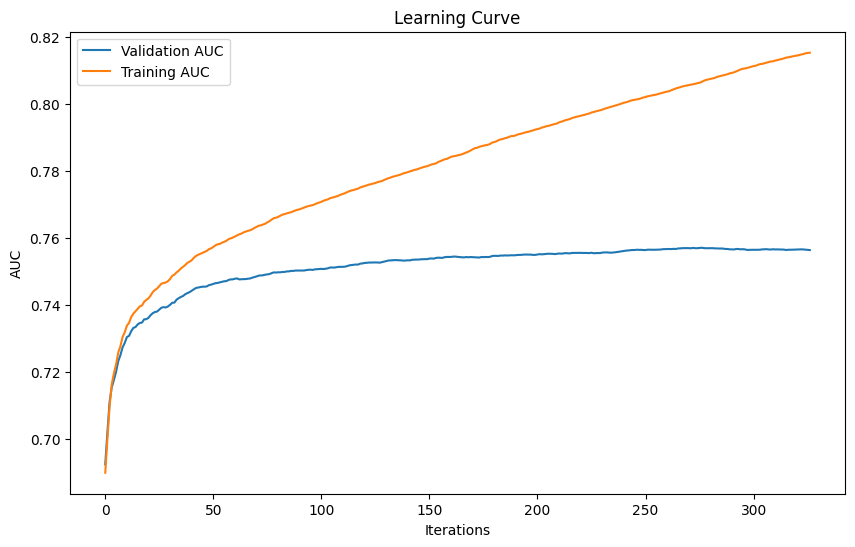

CatBoost Validation AUC: 0.7571


In [ ]:
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# モデルの設定
cat_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 10,
    'random_seed': 42
}

x_tr, x_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# データをCatBoost用に変換
train_pool = Pool(data=x_tr, label=y_tr)
valid_pool = Pool(data=x_va, label=y_va)

# モデルの訓練
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(train_pool, eval_set=[(x_tr, y_tr), (x_va, y_va)], use_best_model=True, early_stopping_rounds=50)

# 学習曲線のプロット
evals_result = cat_model.get_evals_result()

plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_1']['AUC'], label='Validation AUC')
plt.plot(evals_result['validation_0']['AUC'], label='Training AUC')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('Learning Curve')
plt.legend()
plt.show()

# モデルの評価
y_valid_pred = cat_model.predict_proba(x_va)[:, 1]
auc_score = roc_auc_score(y_va, y_valid_pred)
print("CatBoost Validation AUC: {:.4f}".format(auc_score))

In [ ]:
# テストデータをCatBoost用に変換
test_pool = Pool(data=x_test)

# テストデータでの予測
pred_cat = cat_model.predict_proba(test_pool)[:, 1]
print(pred_cat)

[0.04136156 0.30896819 0.25904955 ... 0.15314023 0.2032443  0.16949221]


In [ ]:
# すべてのモデルの予測を平均化
#final_pred = (pred_lgb + pred_xgb + pred_cat) / 3
final_pred = (pred_lgb + pred_cat) / 2

In [ ]:
# 提出ファイルの作成
submission = pd.DataFrame({
    'SK_ID_CURR': id_test['SK_ID_CURR'],
    'TARGET': final_pred
})

# ファイルの保存
submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(submission)

       SK_ID_CURR    TARGET
0          171202  0.044939
1          171203  0.325630
2          171204  0.258825
3          171205  0.146678
4          171206  0.279745
...           ...       ...
61495      232697  0.232991
61496      232698  0.056339
61497      232699  0.117874
61498      232700  0.220518
61499      232701  0.180078

[61500 rows x 2 columns]
